In [1]:
# import library

import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# import data

df = pd.read_csv('Crop Production data.csv')
print(df)

                         State_Name District_Name  Crop_Year      Season  \
0       Andaman and Nicobar Islands      NICOBARS       2000      Kharif   
1       Andaman and Nicobar Islands      NICOBARS       2000      Kharif   
2       Andaman and Nicobar Islands      NICOBARS       2000      Kharif   
3       Andaman and Nicobar Islands      NICOBARS       2000  Whole Year   
4       Andaman and Nicobar Islands      NICOBARS       2000  Whole Year   
...                             ...           ...        ...         ...   
246086                  West Bengal       PURULIA       2014      Summer   
246087                  West Bengal       PURULIA       2014      Summer   
246088                  West Bengal       PURULIA       2014  Whole Year   
246089                  West Bengal       PURULIA       2014      Winter   
246090                  West Bengal       PURULIA       2014      Winter   

                       Crop      Area  Production  
0                  Arecanut    1254

## India Political Map

![India Map](https://www.mapsofindia.com/images2/india-map.jpg)

# Data Preprocessing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246091 entries, 0 to 246090
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   State_Name     246091 non-null  object 
 1   District_Name  246091 non-null  object 
 2   Crop_Year      246091 non-null  int64  
 3   Season         246091 non-null  object 
 4   Crop           246091 non-null  object 
 5   Area           246091 non-null  float64
 6   Production     242361 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 13.1+ MB


Production field has some null values

In [4]:
# Ckeck for duplicate tuples

if df[df.duplicated(subset=['State_Name', 'District_Name', 'Crop_Year', 'Season', 'Crop'])].empty:
    print("No duplicate rows found")
else:
    print("Duplicate rows found")

No duplicate rows found


In [5]:
df.describe()

,Crop_Year,Area,Production
count,246091.000000,2.460910e+05,2.423610e+05
mean,2005.643018,1.200282e+04,5.825034e+05
std,4.952164,5.052340e+04,1.706581e+07
min,1997.000000,4.000000e-02,0.000000e+00
25%,2002.000000,8.000000e+01,8.800000e+01
50%,2006.000000,5.820000e+02,7.290000e+02
75%,2010.000000,4.392000e+03,7.023000e+03
max,2015.000000,8.580100e+06,1.250800e+09


There is zero production for certain crops symbolising drought.

Area and Production fields are Ratio scaled type of data. And the range of these data varies exponentially. Hence, logarithmic transform would be helpful in data analysis.

In [6]:
# data cleaning - Removing tuples having null values or zero production
df1 = df[(df['Production'] != 0) & df['Production'].notna()].copy()

# data preprocessing - group by state, removing district
df2 = df1.drop(columns=['District_Name'])
df2 = df2.groupby(['State_Name', 'Crop', 'Crop_Year', 'Season']).agg({'Production': 'sum', 'Area': 'sum'}).reset_index()

# data preprocessing - log transformation
df1['log_area'] = np.log(df1['Area'])
df1['log_production'] = np.log(df1['Production'])
df2['log_area'] = np.log(df2['Area'])
df2['log_production'] = np.log(df2['Production'])

In [7]:
df1.describe()

,Crop_Year,Area,Production,log_area,log_production
count,238838.000000,2.388380e+05,2.388380e+05,238838.000000,238838.000000
mean,2005.676178,1.234239e+04,5.910957e+05,6.442350,6.733928
std,4.975472,5.120969e+04,1.719107e+07,2.817581,3.200948
min,1997.000000,1.000000e-01,1.000000e-02,-2.302585,-4.605170
25%,2002.000000,9.100000e+01,9.900000e+01,4.510860,4.595120
50%,2006.000000,6.340550e+02,7.840000e+02,6.452136,6.664409
75%,2010.000000,4.700000e+03,7.306270e+03,8.455318,8.896488
max,2015.000000,8.580100e+06,1.250800e+09,15.964956,20.947049


# Drought Analysis

In [8]:
df_drought = df[(df['Production'] == 0)]

# Statewise and Yearwise
counts = df_drought.groupby(['State_Name', 'Crop_Year'])['Area'].sum().reset_index(name='sum_area')

# Contigency Table
pivot_table = counts.pivot_table(index='State_Name', columns='Crop_Year', values='sum_area', fill_value=0)
pivot_table['Total'] = pivot_table.sum(axis=1)
pivot_table.loc['Total'] = pivot_table.sum()

print(pivot_table)

Crop_Year            1999  2000   2001    2002    2003  2004  2012  2013  \
State_Name                                                                 
Andhra Pradesh          0     2      0   35724   29409     0     0     0   
Assam                   0     0      0       0   12175     0     0     0   
Bihar                   0     1      0       0      14     0     0     0   
Chhattisgarh            0     1      0       2       1     2     0     0   
Gujarat             11300   300    100     200       0     0   100     0   
Haryana             11378  9075  11376   22769    8402     0     0     0   
Himachal Pradesh      372   159      0      41       0     0     0     0   
Jammu and Kashmir       0     0      0   58006   60692     0     0     0   
Karnataka               0     0      0      12      27     0     0     0   
Kerala                  0     0      0   69561   67223     0     0     0   
Madhya Pradesh         14     8      3  105363  112674     0     0     0   
Maharashtra 

In [9]:
total_area = df.groupby(['State_Name', 'Crop_Year'])['Area'].sum().reset_index(name='total_area')

merged_df = pd.merge(counts, total_area, on=['State_Name', 'Crop_Year'], how='outer')
merged_df['ratio'] = np.log(merged_df['sum_area'] / merged_df['total_area'])

pivot_table = merged_df.pivot_table(index='State_Name', columns='Crop_Year', values='ratio', fill_value=0)
print(pivot_table)

Crop_Year               1999       2000       2001       2002       2003  \
State_Name                                                                 
Andhra Pradesh      0.000000 -15.149111   0.000000  -5.274700  -5.524016   
Assam               0.000000   0.000000   0.000000   0.000000  -5.640862   
Bihar               0.000000 -15.861845   0.000000   0.000000 -13.235113   
Chhattisgarh        0.000000 -15.468963   0.000000 -14.797717 -15.537521   
Gujarat            -6.583764 -10.199386 -11.369898 -10.615788   0.000000   
Haryana            -6.171160  -6.401791  -6.199962  -5.464447  -6.515516   
Himachal Pradesh   -7.723839  -8.566233   0.000000  -9.940783   0.000000   
Jammu and Kashmir   0.000000   0.000000   0.000000  -2.855762  -2.836279   
Karnataka           0.000000   0.000000   0.000000 -13.752941 -12.903063   
Kerala              0.000000   0.000000   0.000000  -3.701062  -3.444969   
Madhya Pradesh    -14.134822 -14.567857 -15.617481  -5.147305  -5.165676   
Maharashtra 

The data shows the presence of major drought beginning from 1999 to 2004. It was at its peak on 2002.
The drought affected southern states of Kerala, Tamil Nadu, Telangana and Andra Pradesh from 2002-2003.
The central and western part of the country had droughts from 1999-2004
Jammu and Kashmir and Kerala were affected mostly.  Whereas Rajasthan, Haryana and Himachal Pradesh were also severly affected.

# Correlation Matrix

                Crop_Year      Area  Production  log_area  log_production
Crop_Year        1.000000 -0.027791    0.006668 -0.065594       -0.030678
Area            -0.027791  1.000000    0.040487  0.414915        0.373244
Production       0.006668  0.040487    1.000000  0.054072        0.135647
log_area        -0.065594  0.414915    0.054072  1.000000        0.887427
log_production  -0.030678  0.373244    0.135647  0.887427        1.000000


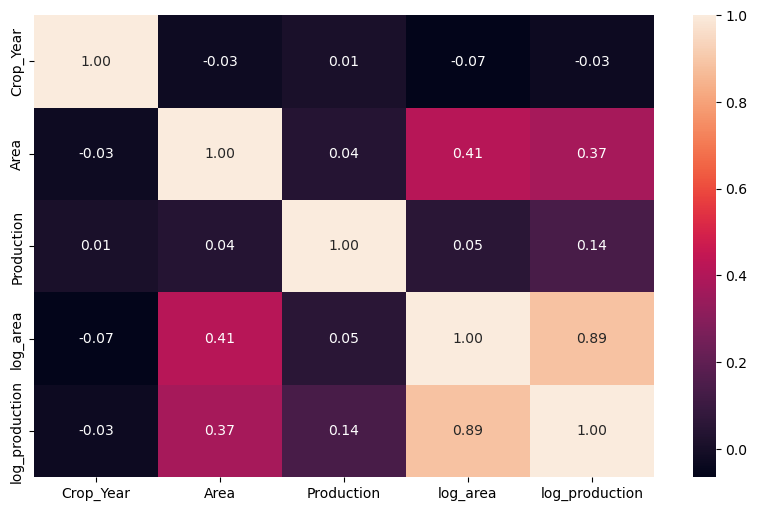

In [10]:
matrix = df1.corr()
print(matrix)

plt.figure(figsize=(10, 6))
sns.heatmap(matrix, annot=True, fmt=".2f")
plt.show()

There is a strong correlation between area and production.
Hence we'll consider the crop density.

In [11]:
# Feature Engineering

df1['Density'] = df1['Production'] / df1['Area']
df1['log_density'] = df1['log_production'] - df1['log_area']

df2['Density'] = df2['Production'] / df2['Area']
df2['log_density'] = df2['log_production'] - df2['log_area']

In [12]:
df2.describe()

,Crop_Year,Production,Area,log_area,log_production,Density,log_density
count,15263.000000,1.526300e+04,1.526300e+04,15263.000000,15263.000000,15263.000000,15263.000000
mean,2005.664745,9.249565e+06,1.931358e+05,9.199603,9.545203,60.031278,0.345601
std,4.961201,2.059237e+08,7.861751e+05,2.937774,3.315564,932.290936,1.477114
min,1997.000000,1.000000e-02,5.000000e-01,-0.693147,-4.605170,0.000017,-10.996082
25%,2002.000000,1.590500e+03,1.560500e+03,7.352762,7.371804,0.565679,-0.569728
50%,2006.000000,1.570200e+04,1.089200e+04,9.295784,9.661543,1.023256,0.022990
75%,2010.000000,1.303950e+05,8.600000e+04,11.362103,11.778324,2.466748,0.902901
max,2015.000000,6.326000e+09,5.080810e+07,17.743566,22.567934,70662.500000,11.165670


# State and District

       State_Name          Area
0   Uttar Pradesh  4.336316e+08
1  Madhya Pradesh  3.298131e+08
2     Maharashtra  3.222062e+08
3       Rajasthan  2.720249e+08
4     West Bengal  2.154052e+08
5       Karnataka  2.029101e+08
6         Gujarat  1.549440e+08
7  Andhra Pradesh  1.315458e+08
8           Bihar  1.282720e+08
9          Punjab  1.267256e+08


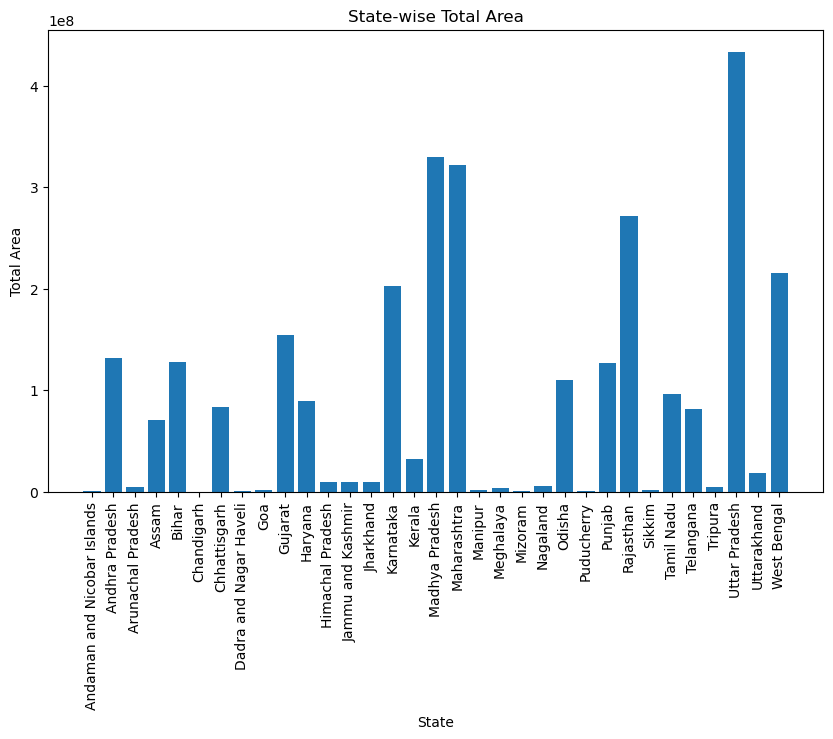

In [13]:
statewise_area = df.groupby('State_Name')['Area'].sum().reset_index()
print(statewise_area.sort_values(by='Area', ascending=False).reset_index().head(n=10)[['State_Name', 'Area']])

plt.figure(figsize=(10, 6))
plt.bar(statewise_area['State_Name'], statewise_area['Area'])
plt.xlabel('State')
plt.ylabel('Total Area')
plt.title('State-wise Total Area')
plt.xticks(rotation=90)
plt.show()

                    State_Name    Production
0                       Kerala  9.788005e+10
1               Andhra Pradesh  1.732459e+10
2                   Tamil Nadu  1.207644e+10
3                Uttar Pradesh  3.234493e+09
4                        Assam  2.111752e+09
5                  West Bengal  1.397904e+09
6                  Maharashtra  1.263641e+09
7                    Karnataka  8.634298e+08
8  Andaman and Nicobar Islands  7.182232e+08
9                       Punjab  5.863850e+08


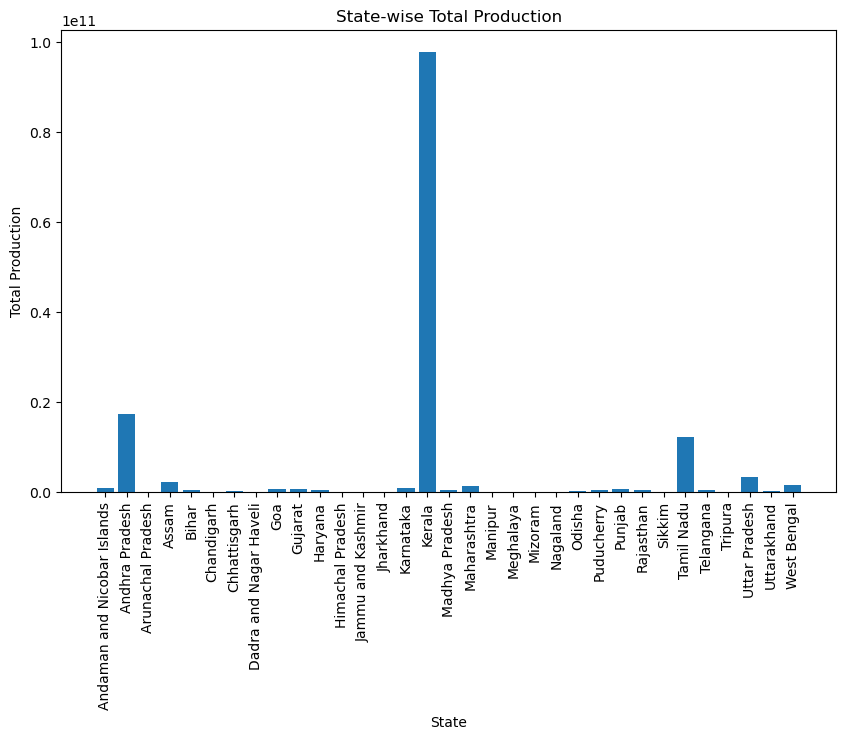

In [14]:
statewise_production = df2.groupby('State_Name')['Production'].sum().reset_index()
print(statewise_production.sort_values(by='Production', ascending=False).reset_index().head(n=10)[['State_Name', 'Production']])

plt.figure(figsize=(10, 6))
plt.bar(statewise_production['State_Name'], statewise_production['Production'])
plt.xlabel('State')
plt.ylabel('Total Production')
plt.title('State-wise Total Production')
plt.xticks(rotation=90)
plt.show()

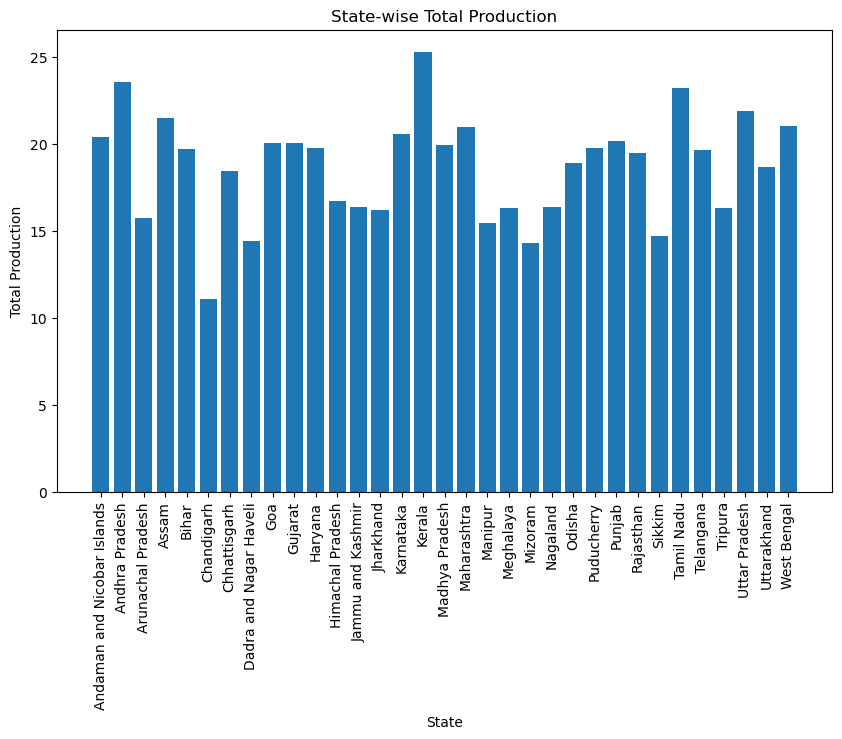

In [15]:
statewise_production = df2.groupby('State_Name')['Production'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(statewise_production['State_Name'], np.log(statewise_production['Production']))
plt.xlabel('State')
plt.ylabel('Total Production')
plt.title('State-wise Total Production')
plt.xticks(rotation=90)
plt.show()

                    State_Name     Density
0                   Puducherry  383.908897
1  Andaman and Nicobar Islands  329.464167
2                       Kerala  295.227646
3                       Punjab  234.483222
4                          Goa  189.451705
5                        Assam  168.319429
6               Andhra Pradesh  166.308631
7                    Telangana  132.933245
8                   Tamil Nadu   55.599328
9                  West Bengal   35.700500


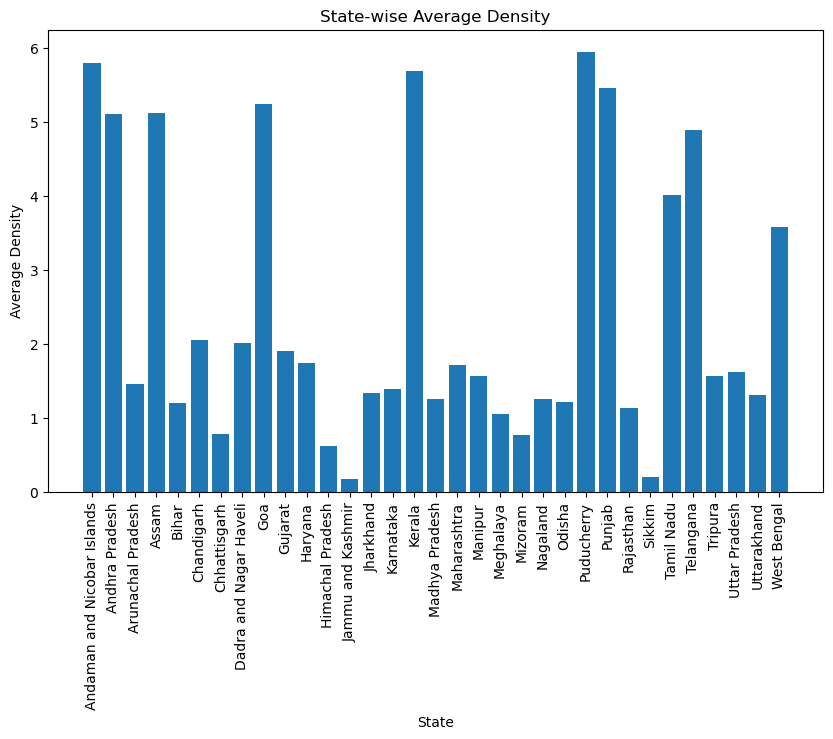

In [16]:
statewise_density = df2.groupby('State_Name')['Density'].mean().reset_index()
print(statewise_density.sort_values(by='Density', ascending=False).reset_index().head(n=10)[['State_Name', 'Density']])

plt.figure(figsize=(10, 6))
plt.bar(statewise_density['State_Name'], np.log(statewise_density['Density']))
plt.xlabel('State')
plt.ylabel('Average Density')
plt.title('State-wise Average Density')
plt.xticks(rotation=90)
plt.show()

In [17]:
print("Top Ten District in terms of Agricultural Land Area")
districtwise_area = df.groupby(['State_Name', 'District_Name'])['Area'].sum().reset_index()
print(districtwise_area.sort_values(by='Area', ascending=False).reset_index().head(n=10)[['State_Name', 'District_Name', 'Area']])

print("\nTop Ten District in terms of Agricultural Production")
districtwise_production = df1.groupby(['State_Name', 'District_Name'])['Production'].sum().reset_index()
print(districtwise_production.sort_values(by='Production', ascending=False).reset_index().head(n=10)[['State_Name', 'District_Name', 'Production']])

print("\nTop Ten District in terms of Agricultural Crop Density")
districtwise_density = df1.groupby(['State_Name', 'District_Name'])['Density'].mean().reset_index()
print(districtwise_density.sort_values(by='Density', ascending=False).reset_index().head(n=10)[['State_Name', 'District_Name', 'Density']])

Top Ten District in terms of Agricultural Land Area
       State_Name   District_Name        Area
0     West Bengal     MURSHIDABAD  24235149.0
1     West Bengal           NADIA  23726486.0
2       Karnataka        GULBARGA  22315289.0
3       Rajasthan          BARMER  20732849.0
4     West Bengal  MEDINIPUR WEST  20694336.0
5     Maharashtra      AHMEDNAGAR  19502613.0
6  Andhra Pradesh       ANANTAPUR  18473186.0
7       Rajasthan          NAGAUR  18333453.0
8     West Bengal       BARDHAMAN  18322752.0
9       Rajasthan           CHURU  17693807.0

Top Ten District in terms of Agricultural Production
       State_Name       District_Name    Production
0          Kerala           KOZHIKODE  1.528074e+10
1          Kerala          MALAPPURAM  1.451840e+10
2          Kerala  THIRUVANANTHAPURAM  1.002271e+10
3          Kerala            THRISSUR  9.923508e+09
4          Kerala              KANNUR  9.783432e+09
5  Andhra Pradesh       EAST GODAVARI  8.271057e+09
6          Kerala       

# Crop Year

   Crop_Year          Area
0       1997  2.317150e+08
1       2010  1.766192e+08
2       2003  1.720881e+08
3       2008  1.712321e+08
4       2006  1.706991e+08
5       2004  1.678784e+08
6       1998  1.669881e+08
7       2009  1.656947e+08
8       2000  1.652975e+08
9       2001  1.652956e+08


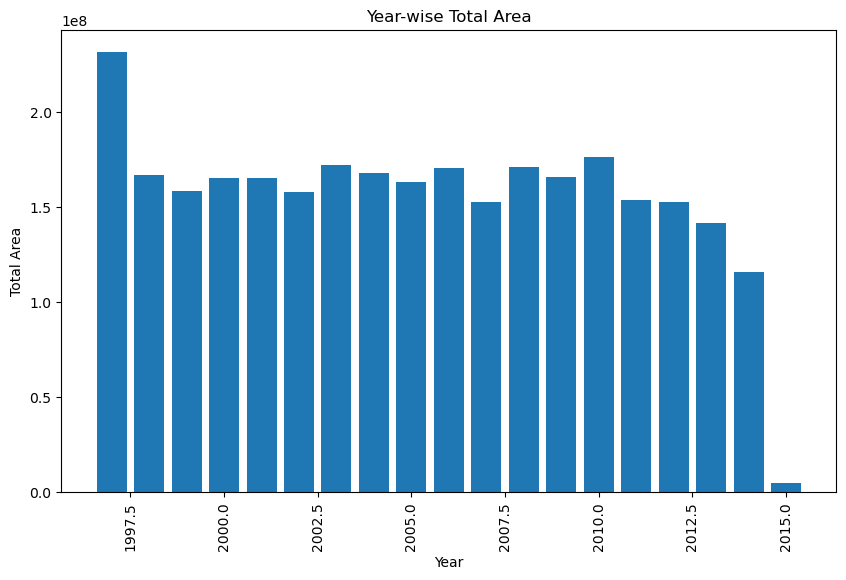

In [18]:
yearwise_area = df.groupby('Crop_Year')['Area'].sum().reset_index()
print(yearwise_area.sort_values(by='Area', ascending=False).reset_index().head(n=10)[['Crop_Year', 'Area']])

plt.figure(figsize=(10, 6))
plt.bar(yearwise_area['Crop_Year'], yearwise_area['Area'])
plt.xlabel('Year')
plt.ylabel('Total Area')
plt.title('Year-wise Total Area')
plt.xticks(rotation=90)
plt.show()

   Crop_Year    Production
0       2011  1.430890e+10
1       2013  1.290359e+10
2       2006  8.681913e+09
3       2014  8.664541e+09
4       2004  8.189462e+09
5       2012  8.171055e+09
6       2005  8.043757e+09
7       2003  7.917974e+09
8       2008  7.717018e+09
9       2002  7.696955e+09


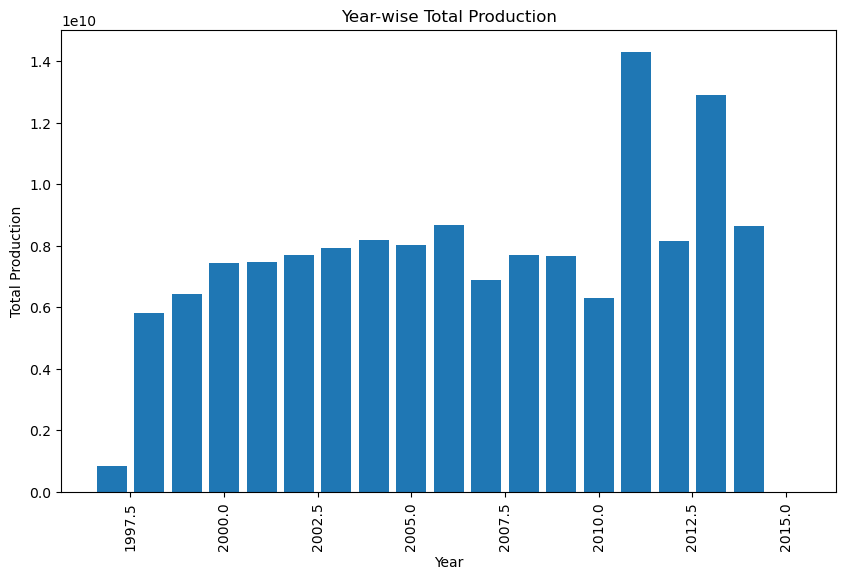

In [19]:
yearwise_production = df2.groupby('Crop_Year')['Production'].sum().reset_index()
print(yearwise_production.sort_values(by='Production', ascending=False).reset_index().head(n=10)[['Crop_Year', 'Production']])

plt.figure(figsize=(10, 6))
plt.bar(yearwise_production['Crop_Year'], yearwise_production['Production'])
plt.xlabel('Year')
plt.ylabel('Total Production')
plt.title('Year-wise Total Production')
plt.xticks(rotation=90)
plt.show()

   Crop_Year     Density
0       2011  157.893146
1       2006   75.071048
2       2004   72.862889
3       2009   67.656331
4       2014   64.640712
5       2001   60.437004
6       2008   59.897589
7       2003   58.688448
8       2013   58.475705
9       2000   57.662560


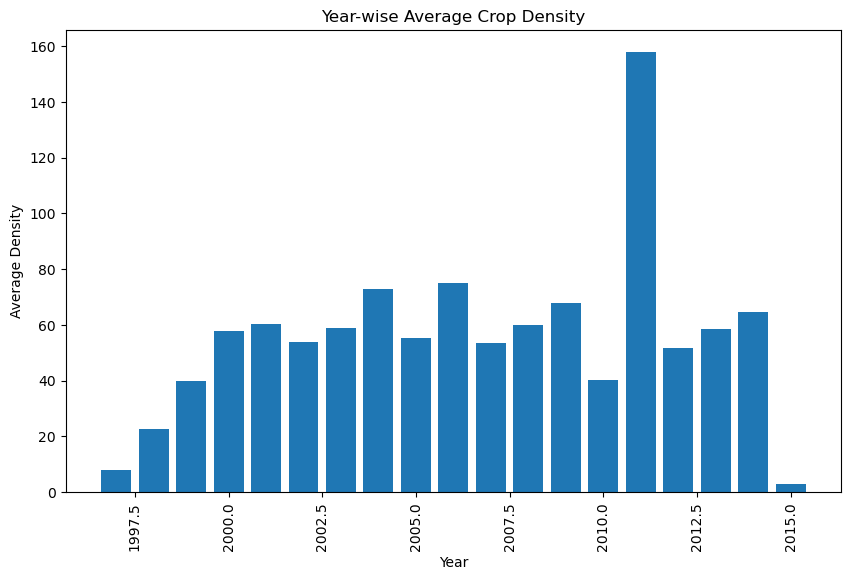

In [20]:
yearwise_density = df2.groupby('Crop_Year')['Density'].mean().reset_index()
print(yearwise_density.sort_values(by='Density', ascending=False).reset_index().head(n=10)[['Crop_Year', 'Density']])

plt.figure(figsize=(10, 6))
plt.bar(yearwise_density['Crop_Year'], yearwise_density['Density'])
plt.xlabel('Year')
plt.ylabel('Average Density')
plt.title('Year-wise Average Crop Density')
plt.xticks(rotation=90)
plt.show()

# Season

       Season          Area
0      Kharif  1.404845e+09
1        Rabi  9.479874e+08
2  Whole Year  2.573005e+08
3      Winter  2.195979e+08
4      Summer  7.598406e+07
5      Autumn  4.807113e+07


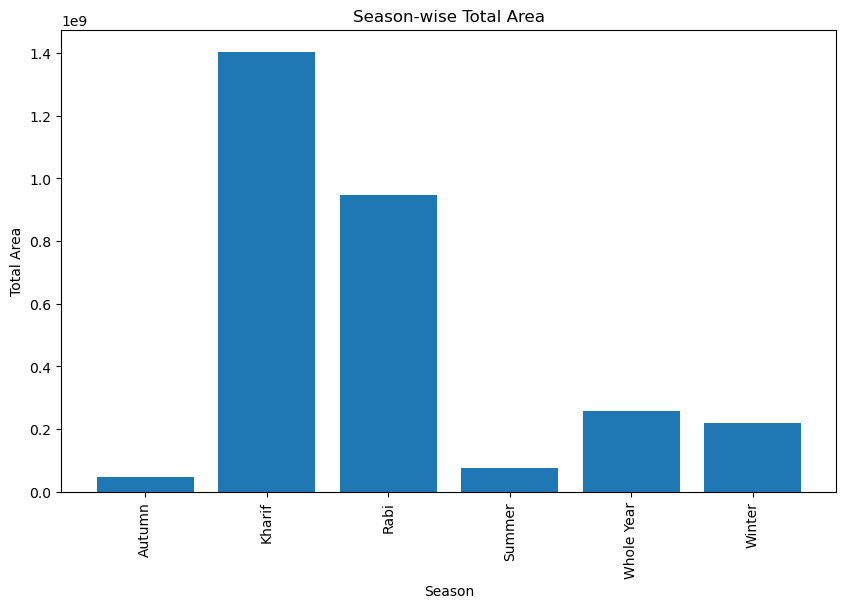

In [21]:
seasonwise_area = df.groupby('Season')['Area'].sum().reset_index()
print(seasonwise_area.sort_values(by='Area', ascending=False).reset_index()[['Season', 'Area']])

plt.figure(figsize=(10, 6))
plt.bar(seasonwise_area['Season'], seasonwise_area['Area'])
plt.xlabel('Season')
plt.ylabel('Total Area')
plt.title('Season-wise Total Area')
plt.xticks(rotation=90)
plt.show()

       Season    Production
0  Whole Year  1.344248e+11
1      Kharif  4.029970e+09
2        Rabi  2.051688e+09
3      Winter  4.345498e+08
4      Summer  1.706579e+08
5      Autumn  6.441377e+07


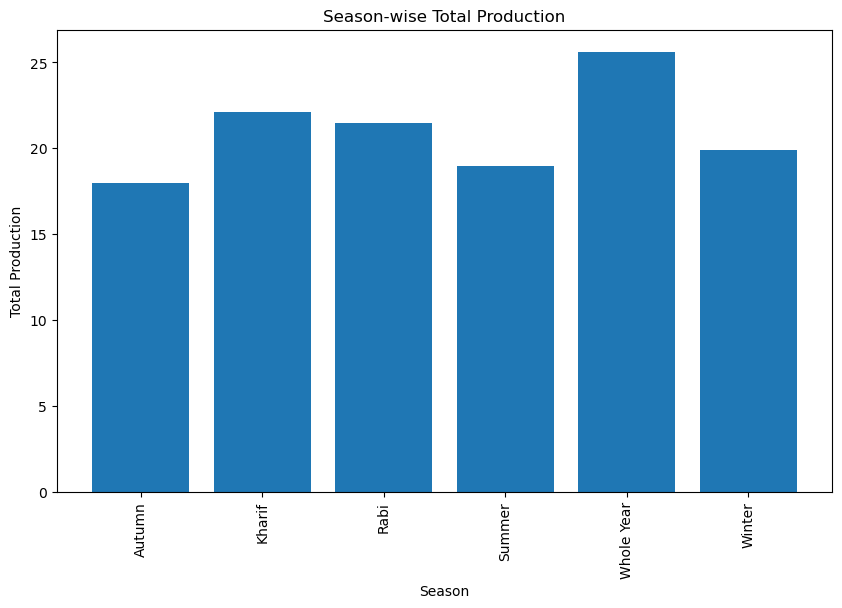

In [22]:
seasonwise_production = df2.groupby('Season')['Production'].sum().reset_index()
print(seasonwise_production.sort_values(by='Production', ascending=False).reset_index()[['Season', 'Production']])

plt.figure(figsize=(10, 6))
plt.bar(seasonwise_production['Season'], np.log(seasonwise_production['Production']))
plt.xlabel('Season')
plt.ylabel('Total Production')
plt.title('Season-wise Total Production')
plt.xticks(rotation=90)
plt.show()

       Season     Density
0  Whole Year  260.846581
1      Winter    7.192470
2      Autumn    4.962448
3      Summer    2.994708
4      Kharif    2.542741
5        Rabi    1.895293


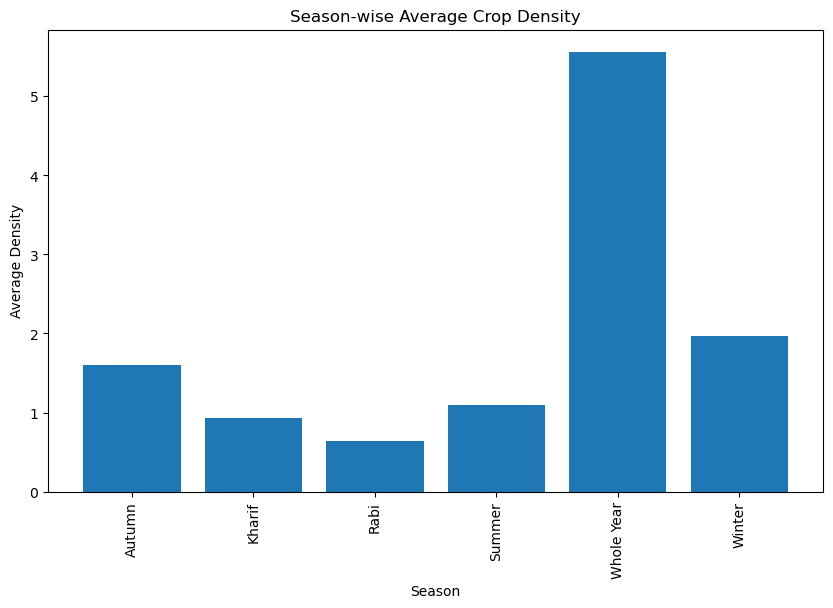

In [23]:
seasonwise_density = df2.groupby('Season')['Density'].mean().reset_index()
print(seasonwise_density.sort_values(by='Density', ascending=False).reset_index()[['Season', 'Density']])

plt.figure(figsize=(10, 6))
plt.bar(seasonwise_density['Season'], np.log(seasonwise_density['Density']))
plt.xlabel('Season')
plt.ylabel('Average Density')
plt.title('Season-wise Average Crop Density')
plt.xticks(rotation=90)
plt.show()

# Crop

                   Crop          Area
0                  Rice  7.471253e+08
1                 Wheat  4.707136e+08
2          Cotton(lint)  1.565681e+08
3                 Bajra  1.411408e+08
4                 Jowar  1.377159e+08
5              Soyabean  1.354508e+08
6                 Maize  1.217467e+08
7                  Gram  1.182080e+08
8             Groundnut  1.027354e+08
9     Rapeseed &Mustard  8.658064e+07
10            Sugarcane  7.667598e+07
11            Arhar/Tur  5.779154e+07
12       Oilseeds total  5.536658e+07
13    Moong(Green Gram)  4.857221e+07
14                 Urad  4.757572e+07
15            Guar seed  3.353516e+07
16              Coconut  2.838168e+07
17              Sesamum  2.809915e+07
18      Total foodgrain  2.530980e+07
19                 Ragi  2.482924e+07
20            Sunflower  2.424815e+07
21         Pulses total  2.275206e+07
22               Potato  2.223287e+07
23               Masoor  1.927588e+07
24                Paddy  1.753647e+07
25          

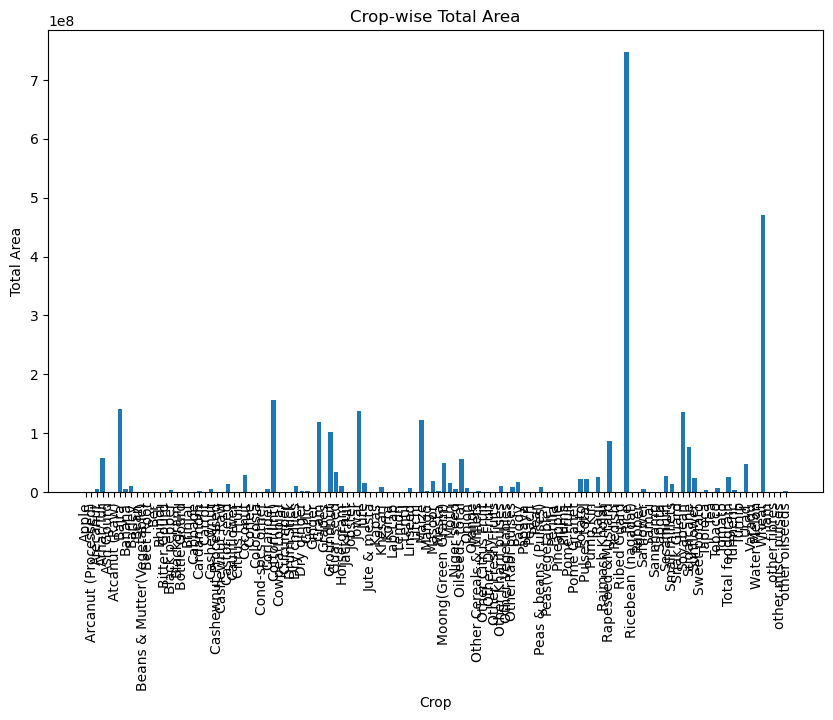

In [24]:
cropwise_area = df.groupby('Crop')['Area'].sum().reset_index()
print(cropwise_area.sort_values(by='Area', ascending=False).reset_index().head(n=30)[['Crop', 'Area']])

plt.figure(figsize=(10, 6))
plt.bar(cropwise_area['Crop'], cropwise_area['Area'])
plt.xlabel('Crop')
plt.ylabel('Total Area')
plt.title('Crop-wise Total Area')
plt.xticks(rotation=90)
plt.show()

                 Crop    Production
0             Coconut  1.299816e+11
1           Sugarcane  5.535682e+09
2                Rice  1.605470e+09
3               Wheat  1.332826e+09
4              Potato  4.248263e+08
5        Cotton(lint)  2.970000e+08
6               Maize  2.733418e+08
7                Jute  1.815582e+08
8              Banana  1.461327e+08
9            Soyabean  1.418372e+08
10              Bajra  1.296810e+08
11              Jowar  1.145983e+08
12          Groundnut  1.117449e+08
13            Tapioca  1.050072e+08
14               Gram  9.941424e+07
15  Rapeseed &Mustard  9.086927e+07
16              Onion  7.245305e+07
17     Oilseeds total  4.386756e+07
18    Total foodgrain  4.327076e+07
19          Arhar/Tur  3.933139e+07
20               Ragi  3.513140e+07
21              Paddy  3.170240e+07
22               Urad  2.241049e+07
23             Barley  2.209827e+07
24           Arecanut  2.034659e+07
25  Moong(Green Gram)  1.830319e+07
26       Dry chillies  1.771

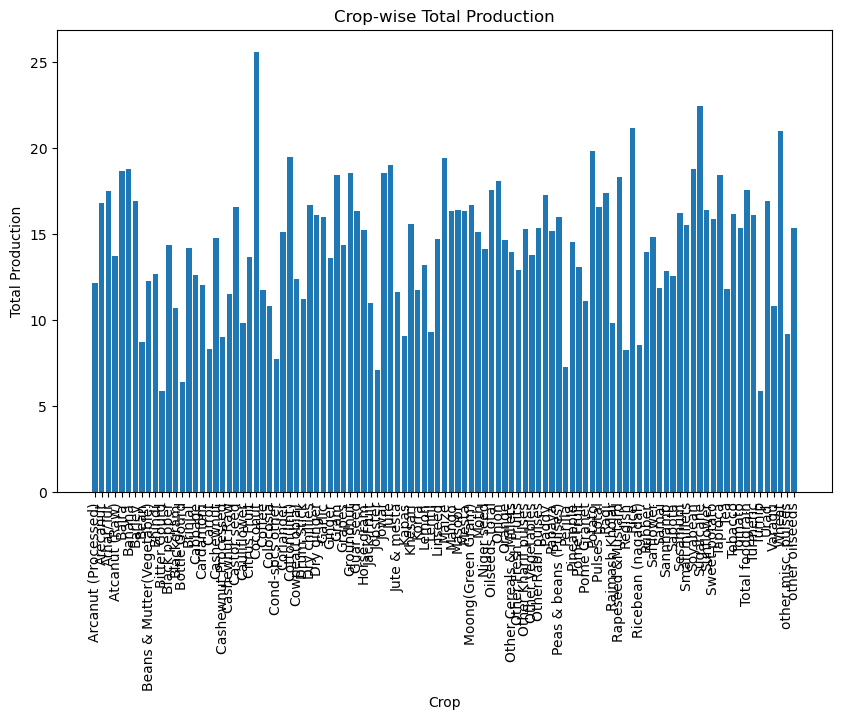

In [25]:
cropwise_production = df2.groupby('Crop')['Production'].sum().reset_index()
print(cropwise_production.sort_values(by='Production', ascending=False).reset_index().head(n=30)[['Crop', 'Production']])

plt.figure(figsize=(10, 6))
plt.bar(cropwise_production['Crop'], np.log(cropwise_production['Production']))
plt.xlabel('Crop')
plt.ylabel('Total Production')
plt.title('Crop-wise Total Production')
plt.xticks(rotation=90)
plt.show()

                Crop      Density
0            Coconut  5667.302350
1          Sugarcane   207.618447
2             Papaya    41.668237
3             Banana    26.534182
4            Cabbage    24.349568
5             Grapes    20.526463
6            Tapioca    16.451363
7          Pineapple    14.540161
8        Pome Granet    13.426922
9            Brinjal    12.711166
10            Potato    12.523067
11            Tomato    12.421604
12             Onion    11.886901
13            Sapota    10.300844
14            Orange     9.986613
15         Colocosia     9.511450
16        Pome Fruit     8.845809
17      Sweet potato     8.760775
18      Bottle Gourd     8.600000
19       Cauliflower     8.539219
20            Ginger     8.266433
21      Jute & mesta     8.066395
22              Jute     7.986370
23             Lemon     7.212213
24             Mango     6.946732
25      Bitter Gourd     6.676471
26      Citrus Fruit     6.476884
27     Atcanut (Raw)     6.434053
28        Dry 

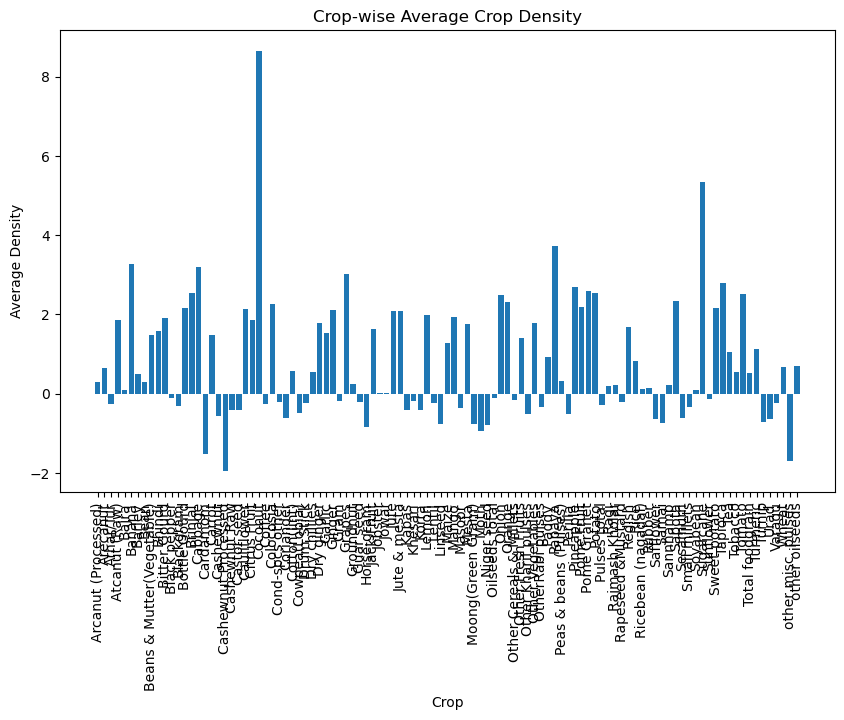

In [26]:
cropwise_density = df2.groupby('Crop')['Density'].mean().reset_index()
print(cropwise_density.sort_values(by='Density', ascending=False).reset_index().head(n=30)[['Crop', 'Density']])

plt.figure(figsize=(10, 6))
plt.bar(cropwise_density['Crop'], np.log(cropwise_density['Density']))
plt.xlabel('Crop')
plt.ylabel('Average Density')
plt.title('Crop-wise Average Crop Density')
plt.xticks(rotation=90)
plt.show()

# Statewise and Seasonwise Crop

In [27]:
statecropwise_production = df2.groupby(['State_Name', 'Crop'])['Production'].sum().reset_index()
print(statecropwise_production.sort_values(by='Production', ascending=False).reset_index().head(n=30)[['State_Name', 'Crop', 'Production']])

                     State_Name       Crop    Production
0                        Kerala    Coconut  9.780304e+10
1                Andhra Pradesh    Coconut  1.680600e+10
2                    Tamil Nadu    Coconut  1.093774e+10
3                 Uttar Pradesh  Sugarcane  2.202875e+09
4                         Assam    Coconut  1.954408e+09
5                   Maharashtra  Sugarcane  9.384860e+08
6                    Tamil Nadu  Sugarcane  8.474968e+08
7                   West Bengal    Coconut  7.178412e+08
8   Andaman and Nicobar Islands    Coconut  7.177900e+08
9                     Karnataka  Sugarcane  5.158455e+08
10                          Goa    Coconut  5.031126e+08
11                Uttar Pradesh      Wheat  4.699118e+08
12                   Puducherry    Coconut  3.791390e+08
13                       Punjab      Wheat  2.769460e+08
14                  West Bengal       Rice  2.580928e+08
15               Andhra Pradesh  Sugarcane  2.267303e+08
16                Uttar Pradesh

In [28]:
districtcropwise_production = df1.groupby(['State_Name', 'District_Name', 'Crop'])['Production'].sum().reset_index()
print(districtcropwise_production.sort_values(by='Production', ascending=False).reset_index().head(n=30)[['State_Name', 'District_Name', 'Crop', 'Production']])

                     State_Name       District_Name     Crop    Production
0                        Kerala           KOZHIKODE  Coconut  1.527871e+10
1                        Kerala          MALAPPURAM  Coconut  1.451252e+10
2                        Kerala  THIRUVANANTHAPURAM  Coconut  1.001337e+10
3                        Kerala            THRISSUR  Coconut  9.920739e+09
4                        Kerala              KANNUR  Coconut  9.780310e+09
5                Andhra Pradesh       EAST GODAVARI  Coconut  8.214998e+09
6                        Kerala           KASARAGOD  Coconut  7.730637e+09
7                        Kerala              KOLLAM  Coconut  7.140793e+09
8                        Kerala            PALAKKAD  Coconut  6.359585e+09
9                        Kerala           ERNAKULAM  Coconut  5.016205e+09
10                       Kerala           ALAPPUZHA  Coconut  4.797217e+09
11               Andhra Pradesh       WEST GODAVARI  Coconut  4.201577e+09
12                       

In [29]:
seasoncropwise_production = df2.groupby(['Season', 'Crop'])['Production'].sum().reset_index()
print(seasoncropwise_production.sort_values(by='Production', ascending=False).reset_index().head(n=30)[['Season', 'Crop', 'Production']])

        Season               Crop    Production
0   Whole Year            Coconut  1.299815e+11
1   Whole Year          Sugarcane  3.745173e+09
2       Kharif          Sugarcane  1.774444e+09
3         Rabi              Wheat  1.323890e+09
4       Kharif               Rice  9.416566e+08
5       Winter               Rice  3.815695e+08
6       Kharif       Cotton(lint)  2.816592e+08
7         Rabi             Potato  2.051821e+08
8   Whole Year             Potato  1.985014e+08
9       Kharif              Maize  1.965474e+08
10      Kharif               Jute  1.810813e+08
11  Whole Year             Banana  1.406728e+08
12      Kharif           Soyabean  1.331343e+08
13      Summer               Rice  1.277028e+08
14      Kharif              Bajra  1.211335e+08
15  Whole Year            Tapioca  1.039236e+08
16        Rabi               Gram  9.574061e+07
17        Rabi  Rapeseed &Mustard  8.976733e+07
18      Kharif          Groundnut  8.658027e+07
19        Rabi               Rice  8.412

# Cocunut, Sugarcane

                    State_Name    Production
0                       Kerala  9.780304e+10
1               Andhra Pradesh  1.680600e+10
2                   Tamil Nadu  1.093774e+10
3                        Assam  1.954408e+09
4                  West Bengal  7.178412e+08
5  Andaman and Nicobar Islands  7.177900e+08
6                          Goa  5.031126e+08
7                   Puducherry  3.791390e+08
8                    Telangana  1.056730e+08
9                    Karnataka  5.676710e+07


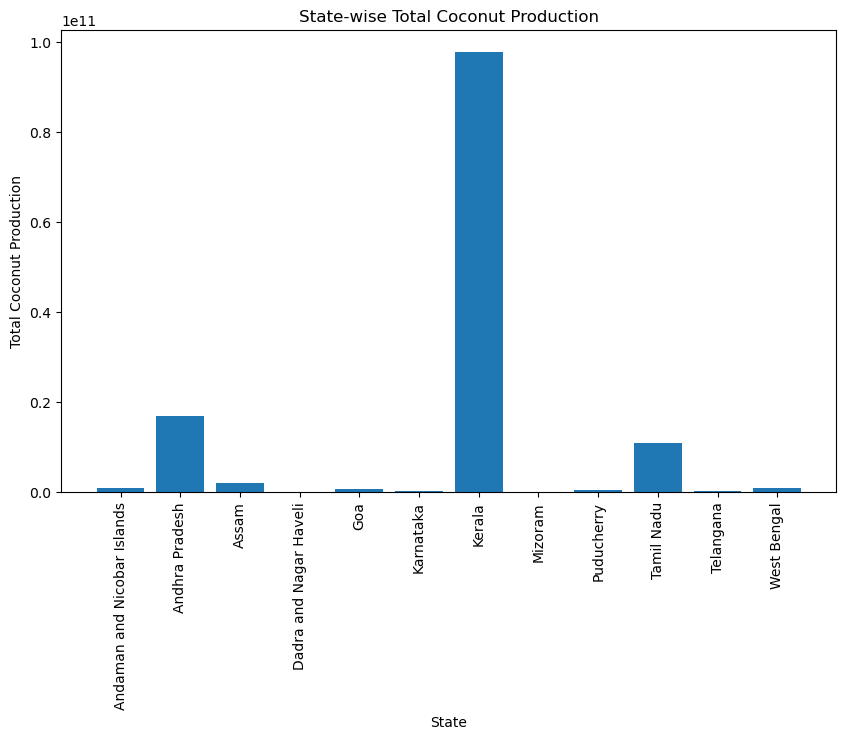

In [30]:
coconut_df = df2[df2['Crop'] == 'Coconut']
statewise_production = coconut_df.groupby('State_Name')['Production'].sum().reset_index()
print(statewise_production.sort_values(by='Production', ascending=False).reset_index().head(n=10)[['State_Name', 'Production']])

plt.figure(figsize=(10, 6))
plt.bar(statewise_production['State_Name'], statewise_production['Production'])
plt.xlabel('State')
plt.ylabel('Total Coconut Production')
plt.title('State-wise Total Coconut Production')
plt.xticks(rotation=90)
plt.show()

   Crop_Year    Production
0       2011  1.359422e+10
1       2013  1.221919e+10
2       2006  8.092567e+09
3       2014  8.067812e+09
4       2004  7.663984e+09
5       2012  7.494435e+09
6       2005  7.453185e+09
7       2003  7.355743e+09
8       2002  7.150889e+09
9       2009  7.041993e+09


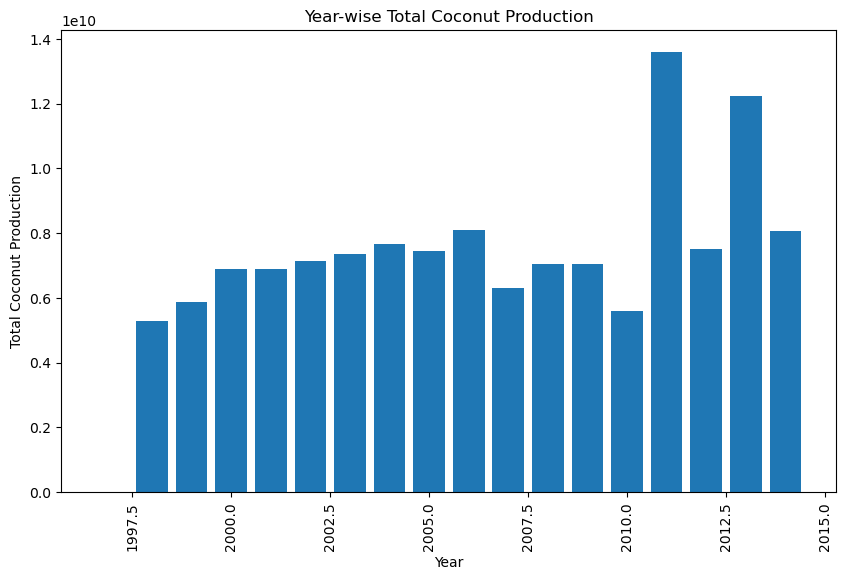

In [31]:
yearwise_production = coconut_df.groupby('Crop_Year')['Production'].sum().reset_index()
print(yearwise_production.sort_values(by='Production', ascending=False).reset_index().head(n=10)[['Crop_Year', 'Production']])

plt.figure(figsize=(10, 6))
plt.bar(yearwise_production['Crop_Year'], yearwise_production['Production'])
plt.xlabel('Year')
plt.ylabel('Total Coconut Production')
plt.title('Year-wise Total Coconut Production')
plt.xticks(rotation=90)
plt.show()

       Season    Production
0  Whole Year  1.299815e+11
1      Kharif  1.265920e+05


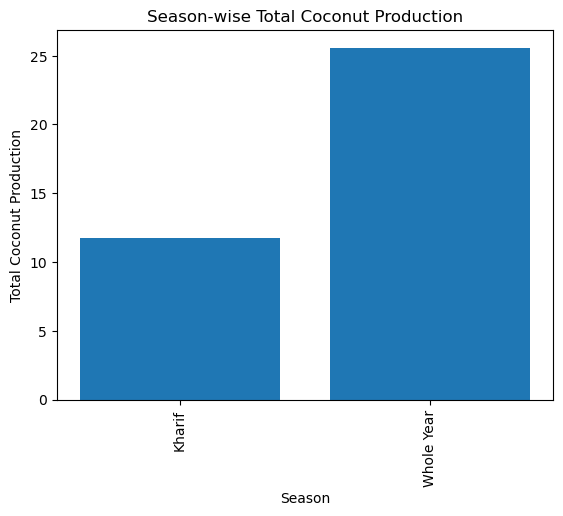

In [32]:
seasonwise_production = coconut_df.groupby('Season')['Production'].sum().reset_index()
print(seasonwise_production.sort_values(by='Production', ascending=False).reset_index()[['Season', 'Production']])

plt.figure()
plt.bar(seasonwise_production['Season'], np.log(seasonwise_production['Production']))
plt.xlabel('Season')
plt.ylabel('Total Coconut Production')
plt.title('Season-wise Total Coconut Production')
plt.xticks(rotation=90)
plt.show()

       State_Name    Production
0   Uttar Pradesh  2.202875e+09
1     Maharashtra  9.384860e+08
2      Tamil Nadu  8.474968e+08
3       Karnataka  5.158455e+08
4  Andhra Pradesh  2.267303e+08
5         Gujarat  2.120228e+08
6         Haryana  1.126809e+08
7           Bihar  1.062272e+08
8     Uttarakhand  9.890274e+07
9          Punjab  8.878000e+07


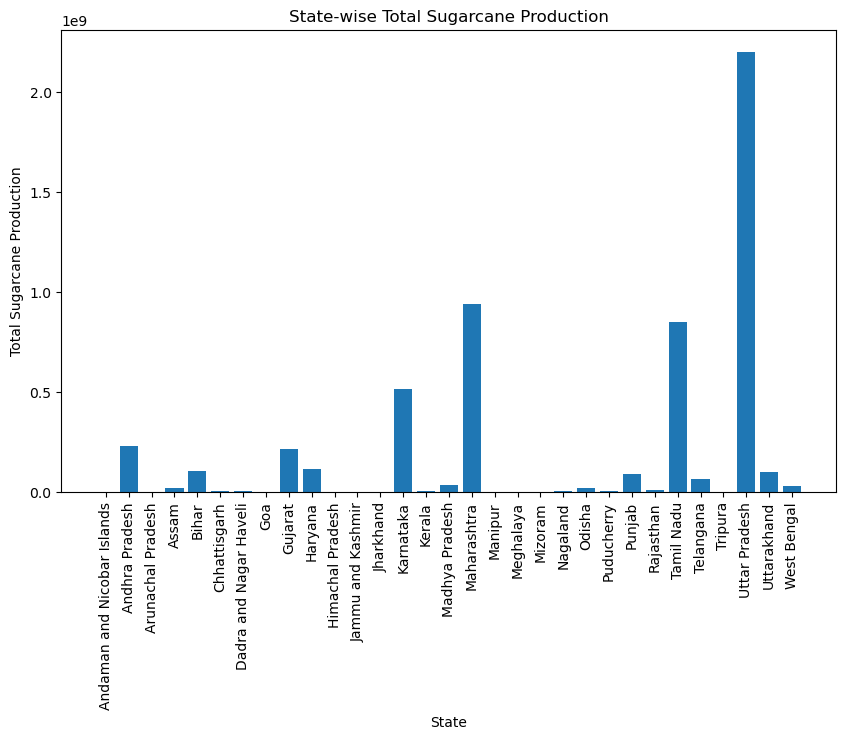

In [33]:
sugarcane_df = df2[df2['Crop'] == 'Sugarcane']
statewise_production = sugarcane_df.groupby('State_Name')['Production'].sum().reset_index()
print(statewise_production.sort_values(by='Production', ascending=False).reset_index().head(n=10)[['State_Name', 'Production']])

plt.figure(figsize=(10, 6))
plt.bar(statewise_production['State_Name'], statewise_production['Production'])
plt.xlabel('State')
plt.ylabel('Total Sugarcane Production')
plt.title('State-wise Total Sugarcane Production')
plt.xticks(rotation=90)
plt.show()

   Crop_Year    Production
0       1997  5.012291e+08
1       2013  3.468605e+08
2       2011  3.453955e+08
3       2008  3.411805e+08
4       2010  3.365308e+08
5       2012  3.354994e+08
6       2014  3.285986e+08
7       2001  2.965126e+08
8       2000  2.961173e+08
9       1999  2.940924e+08


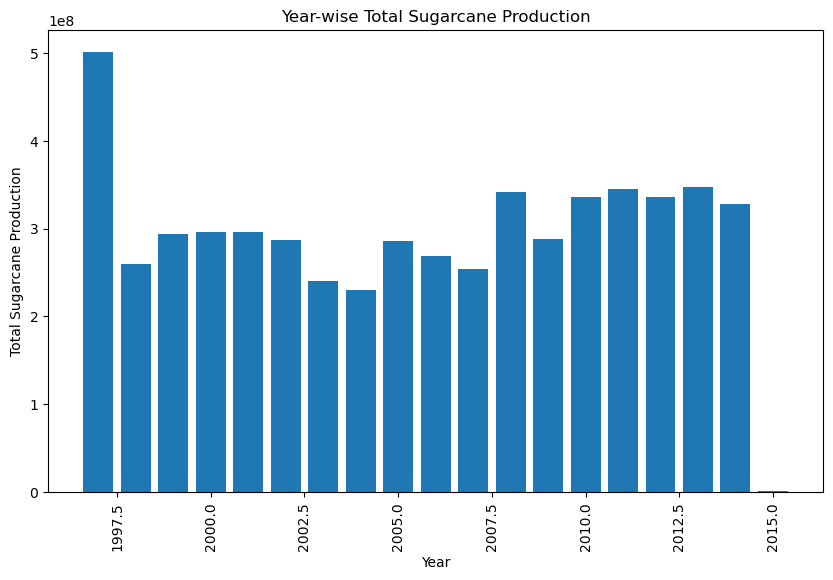

In [34]:
yearwise_production = sugarcane_df.groupby('Crop_Year')['Production'].sum().reset_index()
print(yearwise_production.sort_values(by='Production', ascending=False).reset_index().head(n=10)[['Crop_Year', 'Production']])

plt.figure(figsize=(10, 6))
plt.bar(yearwise_production['Crop_Year'], yearwise_production['Production'])
plt.xlabel('Year')
plt.ylabel('Total Sugarcane Production')
plt.title('Year-wise Total Sugarcane Production')
plt.xticks(rotation=90)
plt.show()

       Season    Production
0  Whole Year  3.745173e+09
1      Kharif  1.774444e+09
2      Winter  1.601724e+07
3        Rabi  2.771600e+04
4      Autumn  1.374295e+04
5      Summer  4.900000e+03


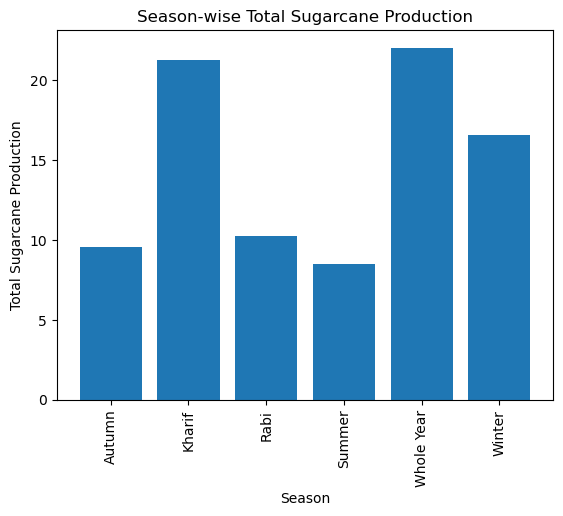

In [35]:
seasonwise_production = sugarcane_df.groupby('Season')['Production'].sum().reset_index()
print(seasonwise_production.sort_values(by='Production', ascending=False).reset_index()[['Season', 'Production']])

plt.figure()
plt.bar(seasonwise_production['Season'], np.log(seasonwise_production['Production']))
plt.xlabel('Season')
plt.ylabel('Total Sugarcane Production')
plt.title('Season-wise Total Sugarcane Production')
plt.xticks(rotation=90)
plt.show()

# Rice, Wheat

       State_Name   Production
0     West Bengal  258092849.0
1   Uttar Pradesh  218793359.0
2          Punjab  179702000.0
3  Andhra Pradesh  143742455.0
4          Odisha  119422742.0
5      Tamil Nadu  100122666.0
6           Bihar   92022922.0
7    Chhattisgarh   81498618.0
8           Assam   71801090.0
9       Telangana   69195676.0


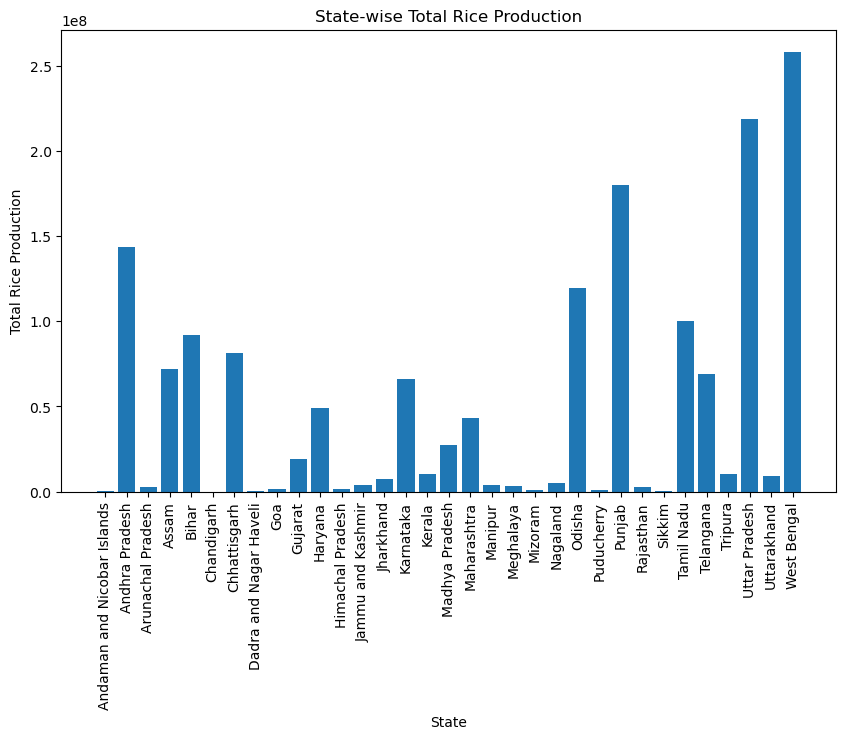

In [36]:
rice_df = df2[df2['Crop'] == 'Rice']
statewise_production = rice_df.groupby('State_Name')['Production'].sum().reset_index()
print(statewise_production.sort_values(by='Production', ascending=False).reset_index().head(n=10)[['State_Name', 'Production']])

plt.figure(figsize=(10, 6))
plt.bar(statewise_production['State_Name'], statewise_production['Production'])
plt.xlabel('State')
plt.ylabel('Total Rice Production')
plt.title('State-wise Total Rice Production')
plt.xticks(rotation=90)
plt.show()

   Crop_Year    Production
0       2014  1.040182e+08
1       2013  1.028728e+08
2       2011  1.020939e+08
3       2012  1.003305e+08
4       2008  9.526127e+07
5       2010  9.517621e+07
6       2007  9.206481e+07
7       2006  9.167629e+07
8       2001  9.005787e+07
9       2005  8.958719e+07


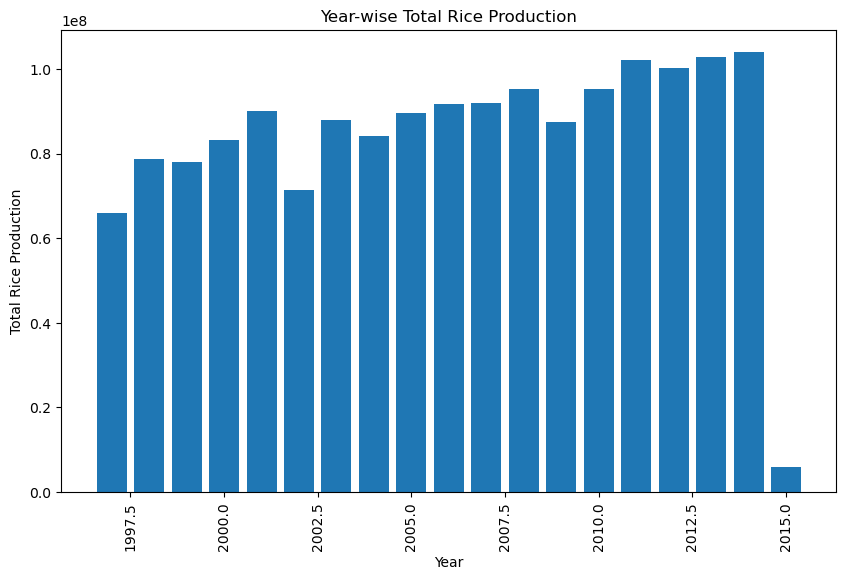

In [37]:
yearwise_production = rice_df.groupby('Crop_Year')['Production'].sum().reset_index()
print(yearwise_production.sort_values(by='Production', ascending=False).reset_index().head(n=10)[['Crop_Year', 'Production']])

plt.figure(figsize=(10, 6))
plt.bar(yearwise_production['Crop_Year'], yearwise_production['Production'])
plt.xlabel('Year')
plt.ylabel('Total Rice Production')
plt.title('Year-wise Total Rice Production')
plt.xticks(rotation=90)
plt.show()

       Season    Production
0      Kharif  9.416566e+08
1      Winter  3.815695e+08
2      Summer  1.277028e+08
3        Rabi  8.412133e+07
4      Autumn  5.185376e+07
5  Whole Year  1.856645e+07


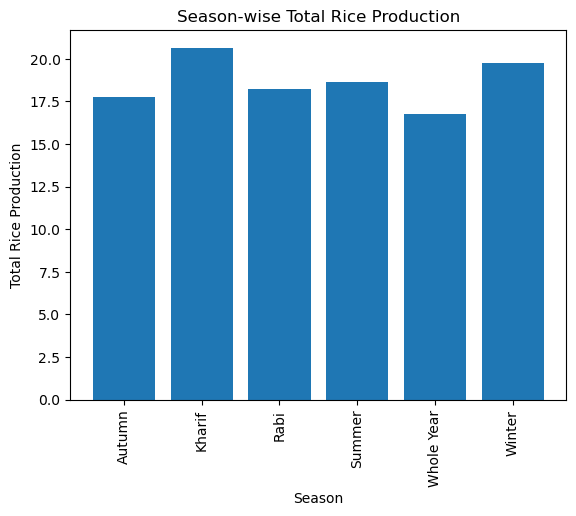

In [38]:
seasonwise_production = rice_df.groupby('Season')['Production'].sum().reset_index()
print(seasonwise_production.sort_values(by='Production', ascending=False).reset_index()[['Season', 'Production']])

plt.figure()
plt.bar(seasonwise_production['Season'], np.log(seasonwise_production['Production']))
plt.xlabel('Season')
plt.ylabel('Total Rice Production')
plt.title('Season-wise Total Rice Production')
plt.xticks(rotation=90)
plt.show()

       State_Name         Area
0   Uttar Pradesh  103380331.0
1     West Bengal  101993454.0
2          Odisha   85677043.0
3    Chhattisgarh   58259645.0
4           Bihar   57733396.0
5          Punjab   48099000.0
6  Andhra Pradesh   46548311.0
7           Assam   44739504.0
8      Tamil Nadu   32351269.0
9  Madhya Pradesh   27583771.0


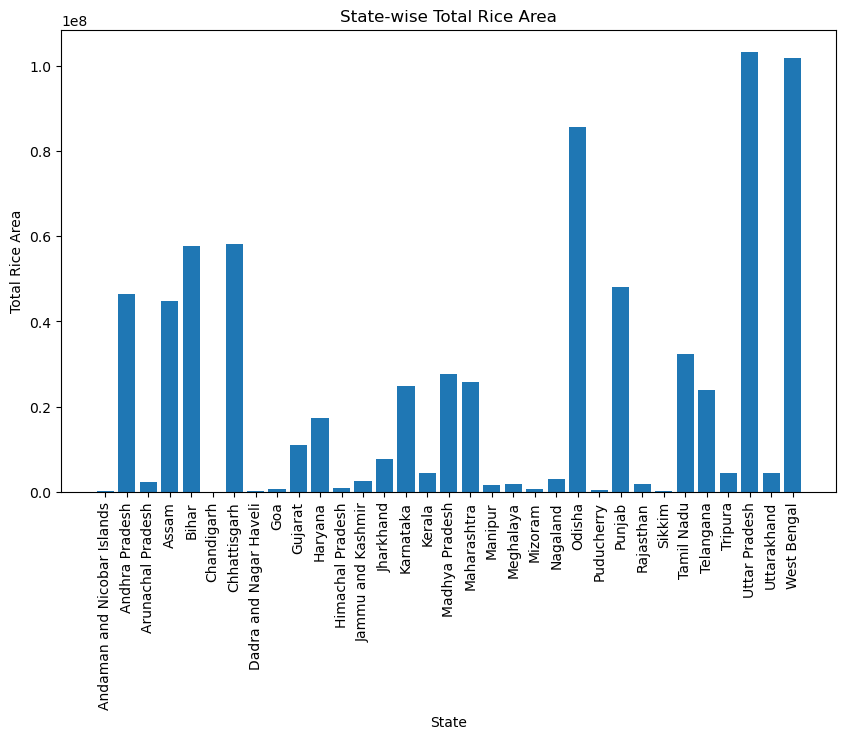

In [39]:
statewise_area = rice_df.groupby('State_Name')['Area'].sum().reset_index()
print(statewise_area.sort_values(by='Area', ascending=False).reset_index().head(n=10)[['State_Name', 'Area']])

plt.figure(figsize=(10, 6))
plt.bar(statewise_area['State_Name'], statewise_area['Area'])
plt.xlabel('State')
plt.ylabel('Total Rice Area')
plt.title('State-wise Total Rice Area')
plt.xticks(rotation=90)
plt.show()

   Crop_Year         Area
0       2012  47098615.00
1       2008  43562353.00
2       2005  43519563.58
3       2000  43190617.00
4       2006  43183913.59
5       2003  43152036.06
6       2001  42745829.00
7       2004  42664665.23
8       2007  42026145.31
9       2011  42011854.74


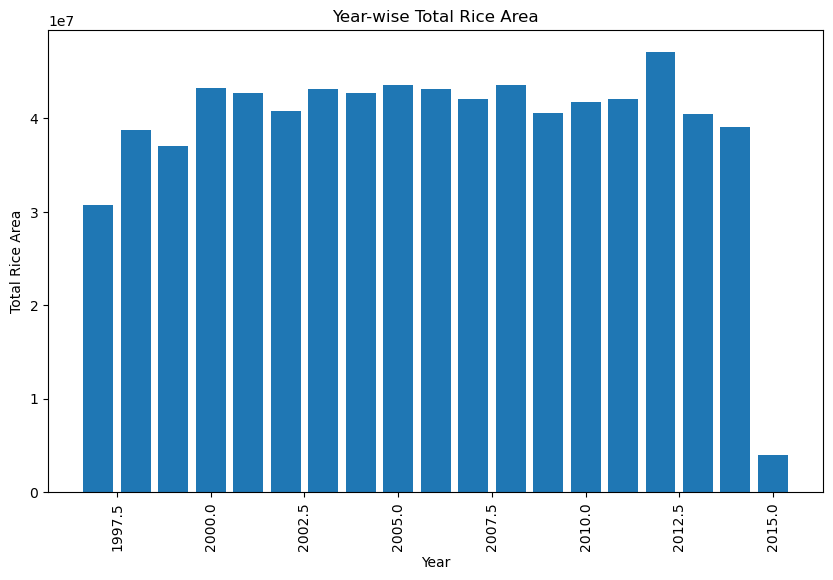

In [40]:
yearwise_area = rice_df.groupby('Crop_Year')['Area'].sum().reset_index()
print(yearwise_area.sort_values(by='Area', ascending=False).reset_index().head(n=10)[['Crop_Year', 'Area']])

plt.figure(figsize=(10, 6))
plt.bar(yearwise_area['Crop_Year'], yearwise_area['Area'])
plt.xlabel('Year')
plt.ylabel('Total Rice Area')
plt.title('Year-wise Total Rice Area')
plt.xticks(rotation=90)
plt.show()

       Season          Area
0      Kharif  4.200768e+08
1      Winter  2.029352e+08
2      Summer  5.207860e+07
3      Autumn  3.996707e+07
4        Rabi  2.394373e+07
5  Whole Year  7.304836e+06


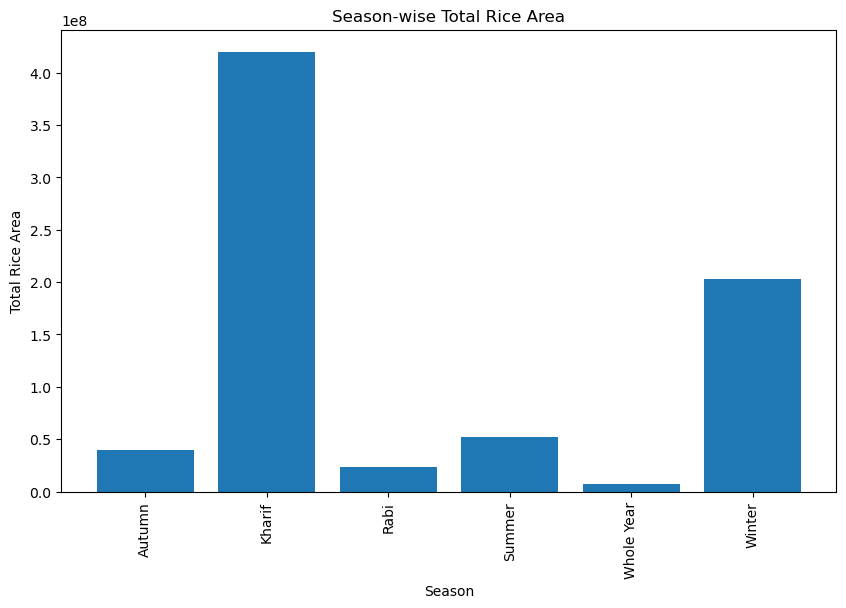

In [41]:
seasonwise_area = rice_df.groupby('Season')['Area'].sum().reset_index()
print(seasonwise_area.sort_values(by='Area', ascending=False).reset_index()[['Season', 'Area']])

plt.figure(figsize=(10, 6))
plt.bar(seasonwise_area['Season'], seasonwise_area['Area'])
plt.xlabel('Season')
plt.ylabel('Total Rice Area')
plt.title('Season-wise Total Rice Area')
plt.xticks(rotation=90)
plt.show()

       State_Name   Production
0   Uttar Pradesh  469911750.0
1          Punjab  276946000.0
2         Haryana  158647000.0
3  Madhya Pradesh  147153856.0
4       Rajasthan   94669124.0
5           Bihar   81020206.0
6         Gujarat   36783800.0
7     Maharashtra   22443475.0
8     West Bengal   15785272.0
9     Uttarakhand   11632116.0


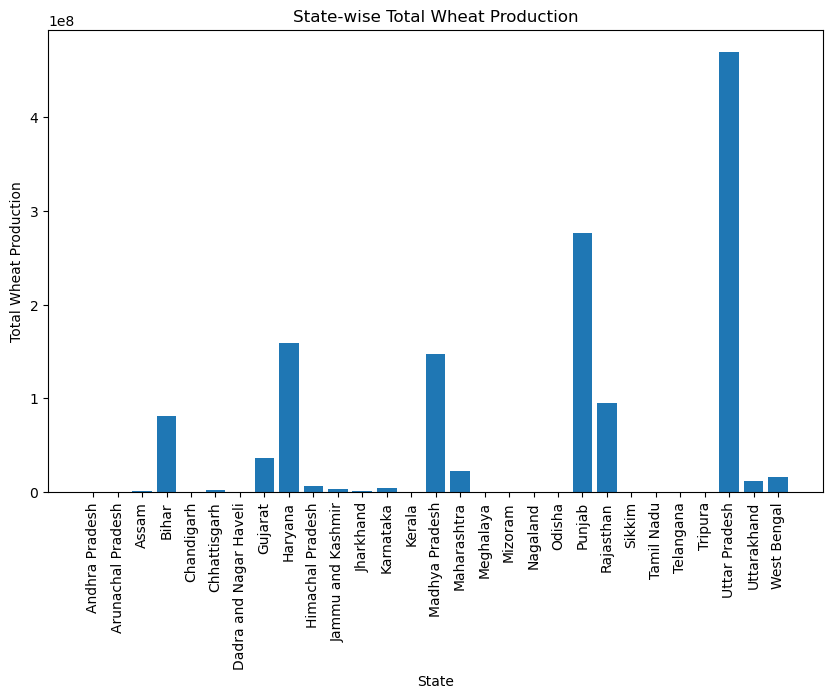

In [42]:
wheat_df = df2[df2['Crop'] == 'Wheat']
statewise_production = wheat_df.groupby('State_Name')['Production'].sum().reset_index()
print(statewise_production.sort_values(by='Production', ascending=False).reset_index().head(n=10)[['State_Name', 'Production']])

plt.figure(figsize=(10, 6))
plt.bar(statewise_production['State_Name'], statewise_production['Production'])
plt.xlabel('State')
plt.ylabel('Total Wheat Production')
plt.title('State-wise Total Wheat Production')
plt.xticks(rotation=90)
plt.show()

   Crop_Year   Production
0       2010  93043112.00
1       2011  91784119.70
2       2012  88022121.40
3       2008  81590346.00
4       2009  80194411.40
5       2007  77599127.90
6       2006  77294678.30
7       2013  75099453.60
8       1999  75068369.00
9       2003  72780554.81


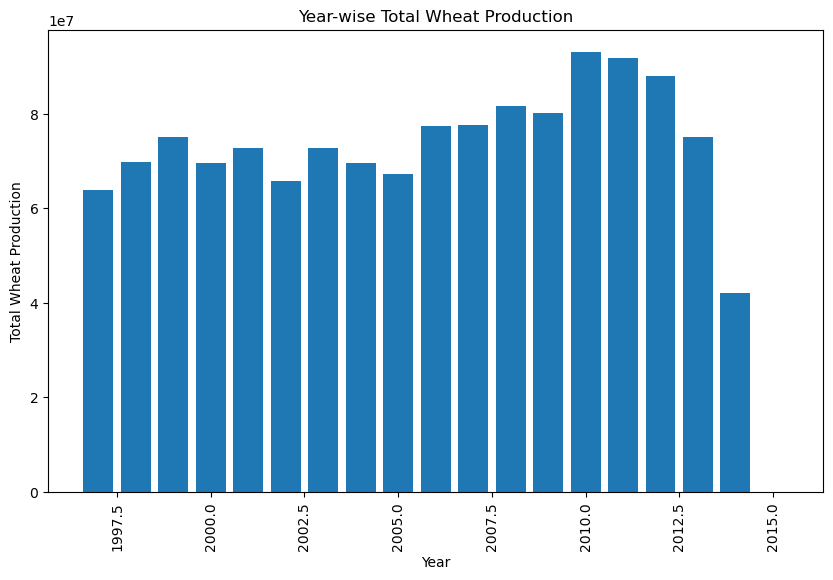

In [43]:
yearwise_production = wheat_df.groupby('Crop_Year')['Production'].sum().reset_index()
print(yearwise_production.sort_values(by='Production', ascending=False).reset_index().head(n=10)[['Crop_Year', 'Production']])

plt.figure(figsize=(10, 6))
plt.bar(yearwise_production['Crop_Year'], yearwise_production['Production'])
plt.xlabel('Year')
plt.ylabel('Total Wheat Production')
plt.title('Year-wise Total Wheat Production')
plt.xticks(rotation=90)
plt.show()

       Season    Production
0        Rabi  1.323890e+09
1  Whole Year  8.865630e+06
2      Summer  5.269320e+04
3      Winter  1.713400e+04
4      Kharif  6.180000e+01


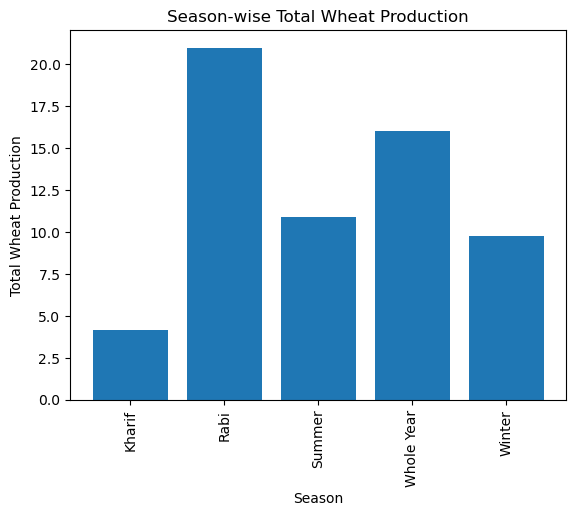

In [44]:
seasonwise_production = wheat_df.groupby('Season')['Production'].sum().reset_index()
print(seasonwise_production.sort_values(by='Production', ascending=False).reset_index()[['Season', 'Production']])

plt.figure()
plt.bar(seasonwise_production['Season'], np.log(seasonwise_production['Production']))
plt.xlabel('Season')
plt.ylabel('Total Wheat Production')
plt.title('Season-wise Total Wheat Production')
plt.xticks(rotation=90)
plt.show()

       State_Name         Area
0   Uttar Pradesh  168614377.0
1  Madhya Pradesh   74390328.0
2          Punjab   62138000.0
3           Bihar   37853724.0
4         Haryana   37734933.0
5       Rajasthan   33613521.0
6     Maharashtra   15856530.0
7         Gujarat   13697300.0
8     West Bengal    6503131.0
9     Uttarakhand    5544511.0


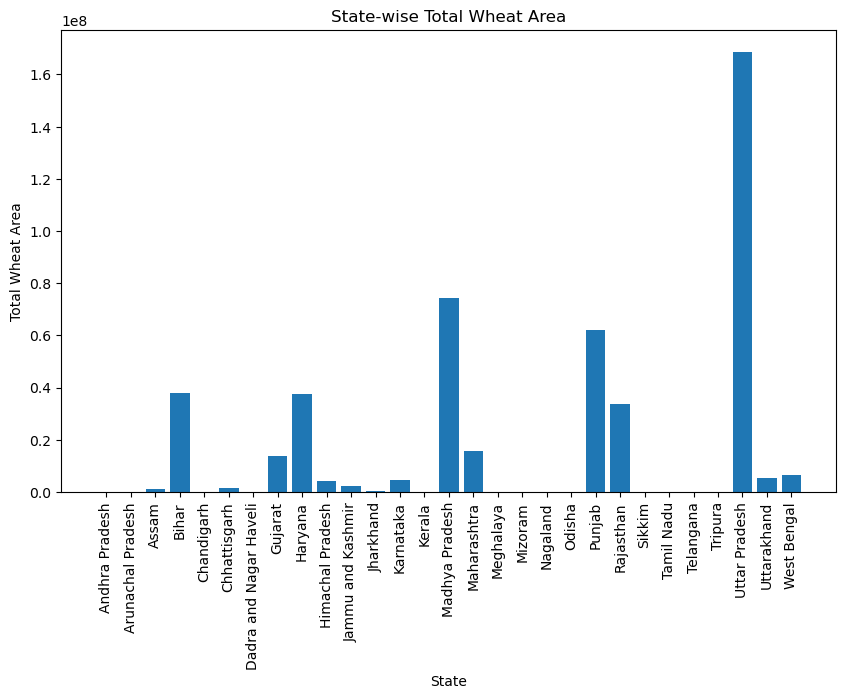

In [45]:
statewise_area = wheat_df.groupby('State_Name')['Area'].sum().reset_index()
print(statewise_area.sort_values(by='Area', ascending=False).reset_index().head(n=10)[['State_Name', 'Area']])

plt.figure(figsize=(10, 6))
plt.bar(statewise_area['State_Name'], statewise_area['Area'])
plt.xlabel('State')
plt.ylabel('Total Wheat Area')
plt.title('State-wise Total Wheat Area')
plt.xticks(rotation=90)
plt.show()

   Crop_Year         Area
0       2010  29837101.00
1       2006  27914944.04
2       2009  27774123.00
3       2008  27772106.00
4       2007  27025547.72
5       2003  26824291.70
6       2004  26786859.58
7       1999  26734280.00
8       1998  26628190.00
9       2011  26471094.00


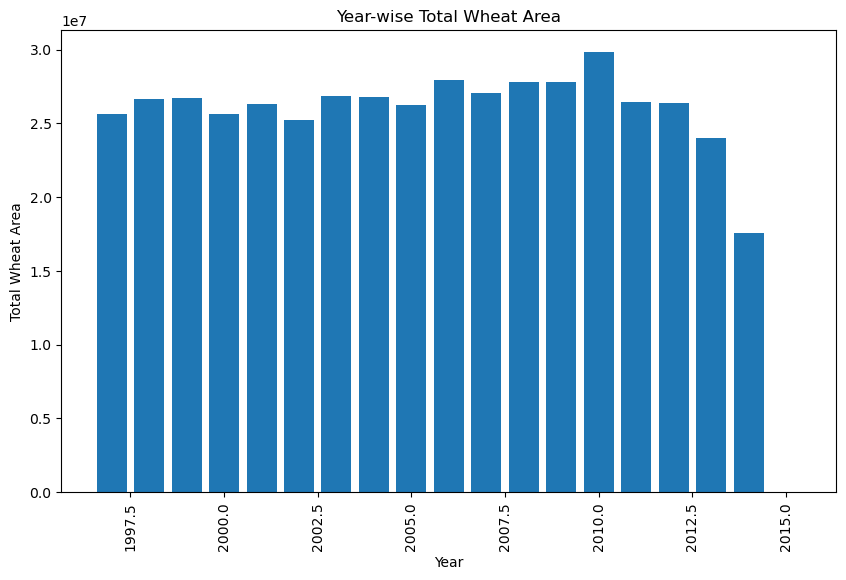

In [46]:
yearwise_area = wheat_df.groupby('Crop_Year')['Area'].sum().reset_index()
print(yearwise_area.sort_values(by='Area', ascending=False).reset_index().head(n=10)[['Crop_Year', 'Area']])

plt.figure(figsize=(10, 6))
plt.bar(yearwise_area['Crop_Year'], yearwise_area['Area'])
plt.xlabel('Year')
plt.ylabel('Total Wheat Area')
plt.title('Year-wise Total Wheat Area')
plt.xticks(rotation=90)
plt.show()

       Season          Area
0        Rabi  4.662077e+08
1  Whole Year  4.459344e+06
2      Summer  3.672500e+04
3      Winter  9.015000e+03
4      Kharif  4.560000e+02


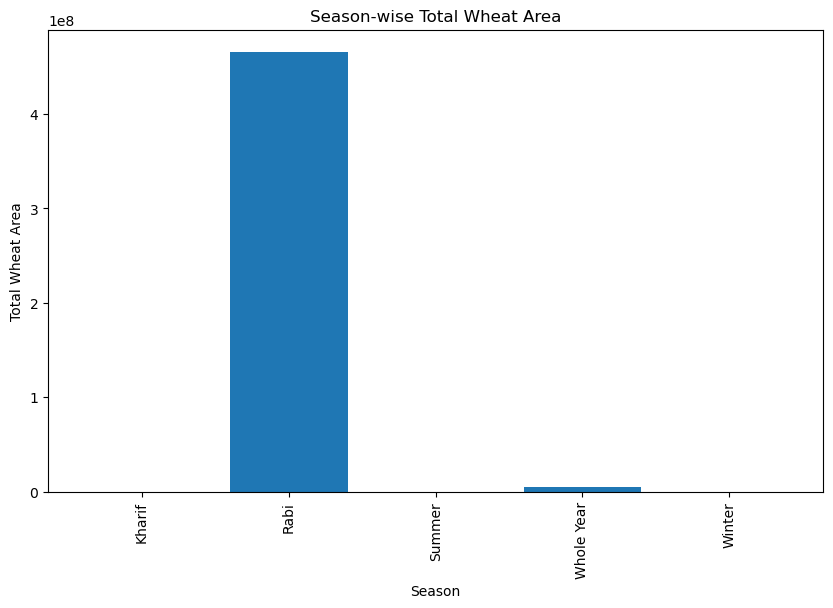

In [47]:
seasonwise_area = wheat_df.groupby('Season')['Area'].sum().reset_index()
print(seasonwise_area.sort_values(by='Area', ascending=False).reset_index()[['Season', 'Area']])

plt.figure(figsize=(10, 6))
plt.bar(seasonwise_area['Season'], seasonwise_area['Area'])
plt.xlabel('Season')
plt.ylabel('Total Wheat Area')
plt.title('Season-wise Total Wheat Area')
plt.xticks(rotation=90)
plt.show()

# Linear Regression

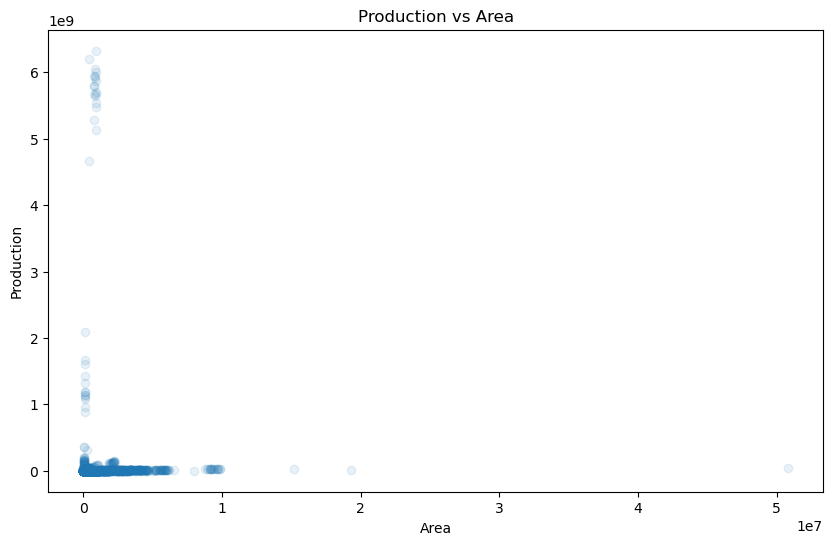

In [48]:
plt.figure(figsize=(10, 6))
plt.scatter(df2['Area'], df2['Production'], alpha=0.1)

plt.title('Production vs Area')
plt.xlabel('Area')
plt.ylabel('Production')
plt.show()

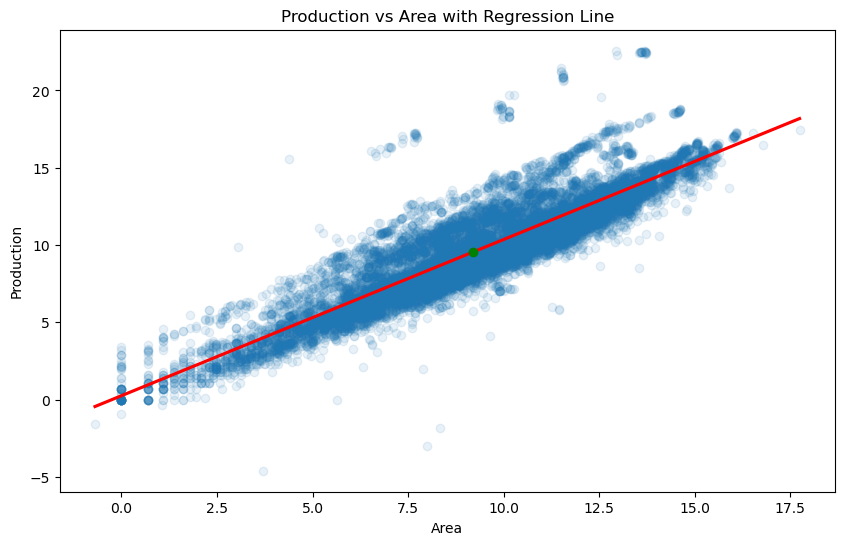

In [49]:
x = df2['log_area']
y = df2['log_production']

plt.figure (figsize=(10, 6))
sns.regplot (x = x, y = y, fit_reg = True, scatter_kws = {'alpha': 0.1}, line_kws = {'color': 'red'})
plt.scatter (np.mean(x), np.mean(y), color="green", zorder=5)

plt.title('Production vs Area with Regression Line')
plt.xlabel('Area')
plt.ylabel('Production')
plt.show()

In [50]:
# import libraries

from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import summary_table
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [51]:
# Anova

reg = ols(formula = "log_production ~ log_area", data = df2)
result = reg.fit()
print (result.summary())

print(anova_lm(result))

                            OLS Regression Results                            
Dep. Variable:         log_production   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                 6.166e+04
Date:                Sun, 14 Jul 2024   Prob (F-statistic):               0.00
Time:                        19:35:00   Log-Likelihood:                -27607.
No. Observations:               15263   AIC:                         5.522e+04
Df Residuals:                   15261   BIC:                         5.523e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2494      0.039      6.345      0.0

log_production = 1.0105 * log_area + 0.2494

log_production - log_area = 0.25 (approx.)

log (production / area) = 0.25

production / area = e ^ 0.25

crop density = 1.28

In [52]:
X = sm.add_constant(x)
model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:         log_production   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                 6.166e+04
Date:                Sun, 14 Jul 2024   Prob (F-statistic):               0.00
Time:                        19:35:00   Log-Likelihood:                -27607.
No. Observations:               15263   AIC:                         5.522e+04
Df Residuals:                   15261   BIC:                         5.523e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2494      0.039      6.345      0.0

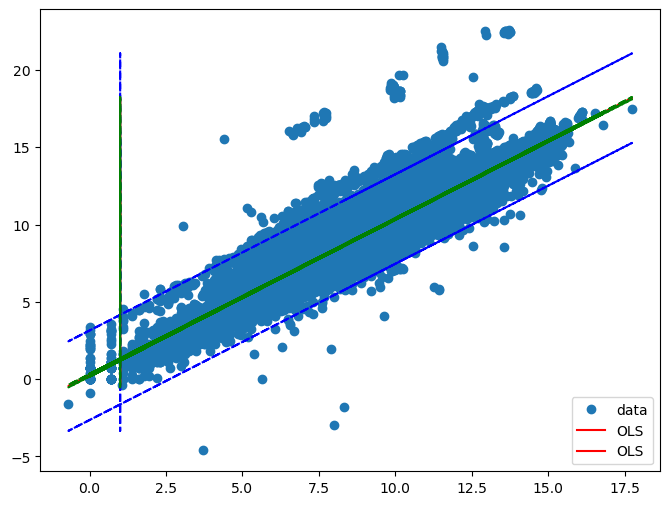

In [53]:
st, data, ss2 = summary_table(result, alpha = 0.05)
fittedvalues = data[:, 2]
predict_mean_se = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, 'o', label="data")
ax.plot(X, fittedvalues, 'r', label='OLS')
ax.plot(X, predict_ci_low, 'b--')
ax.plot(X, predict_ci_upp, 'b--')
ax.plot(X, predict_mean_ci_low, 'g--')
ax.plot(X, predict_mean_ci_upp, 'g--')
ax.legend(loc='best');
plt.show()

In [54]:
# Splitting training and testing dataset

x = df2['log_area'].values.reshape(-1, 1)
y = df2['log_production'].values.reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 88)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(12210, 1) (3053, 1) (12210, 1) (3053, 1)


In [55]:
# Fitting the trained dataset

reg = LinearRegression()
reg.fit(x_train, y_train)
print(reg.intercept_, reg.coef_)

[0.23420964] [[1.01285519]]


In [56]:
# Evaluating model using test dataset

y_predict = reg.predict(x_test)

print(mean_squared_error(y_test, y_predict))
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))

2.218037086306119
0.8022120532267096
0.7991520408066114


C:\Users\Samuel\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

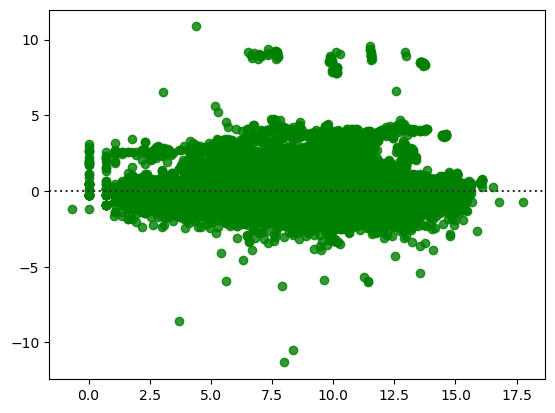

In [57]:
sns.residplot(x, y, color='g')

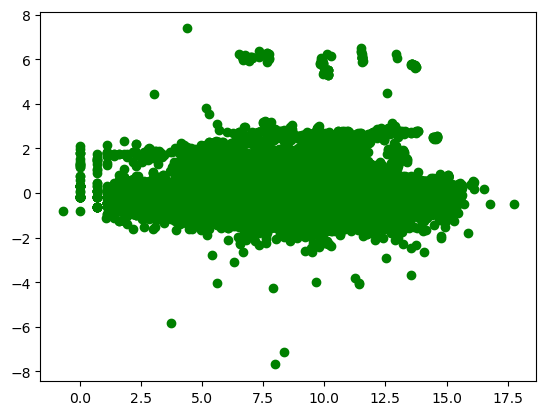

In [58]:
influence = result.get_influence()
resid_area = influence.resid_studentized_external

plt.figure()
plt.scatter(x, resid_area, color = 'green')

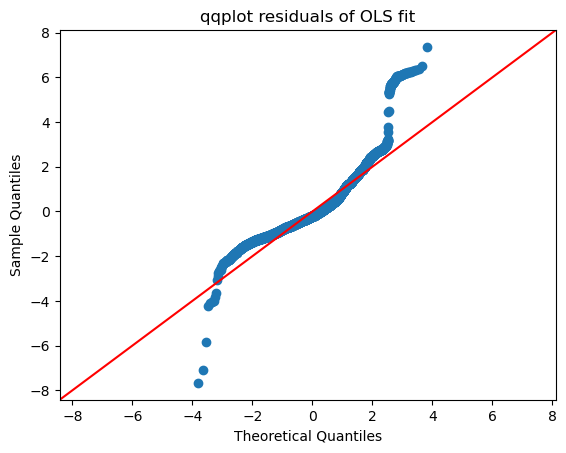

In [59]:
residual = result.resid
probplot = sm.ProbPlot (residual, sc.stats.norm, fit = True)
fig = probplot.qqplot(line = '45')
h = plt.title('qqplot residuals of OLS fit')
plt.show()

# Crop and Crop Density

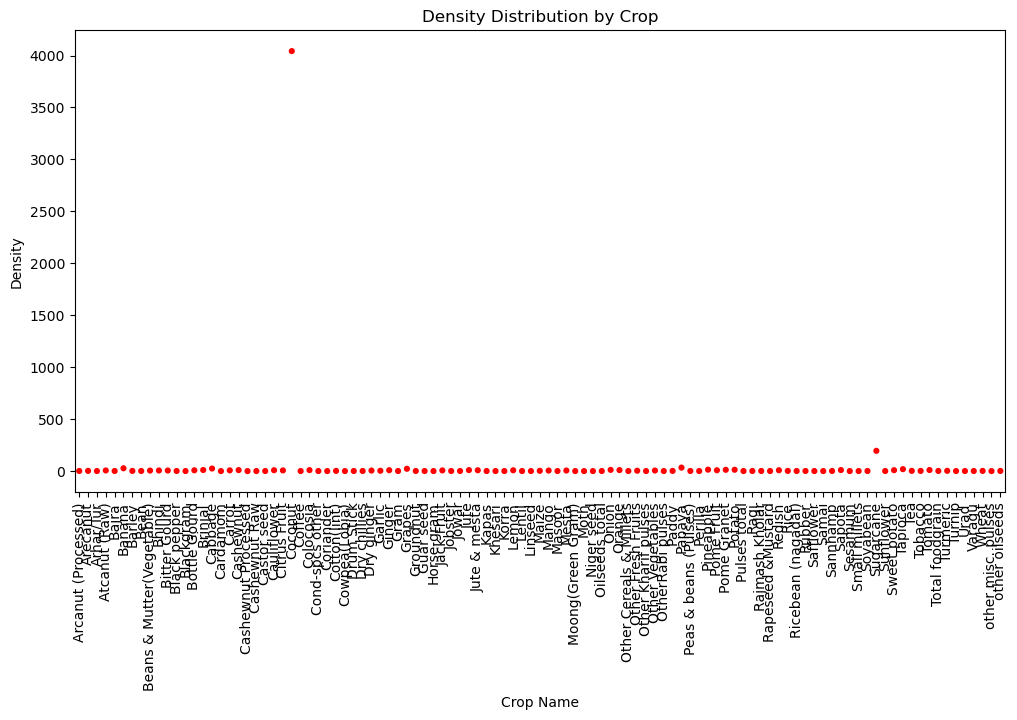

In [60]:
mean_density = df1.groupby('Crop')['Density'].mean().reset_index()

plt.figure(figsize=(12, 6))
#sns.boxplot(x='Crop', y='Density', data=df1)
sns.pointplot(x='Crop', y='Density', data=mean_density, color='red', markers='o', scale=0.5, join=False)
plt.title('Density Distribution by Crop')
plt.xlabel('Crop Name')
plt.ylabel('Density')
plt.xticks(rotation=90)
plt.show()

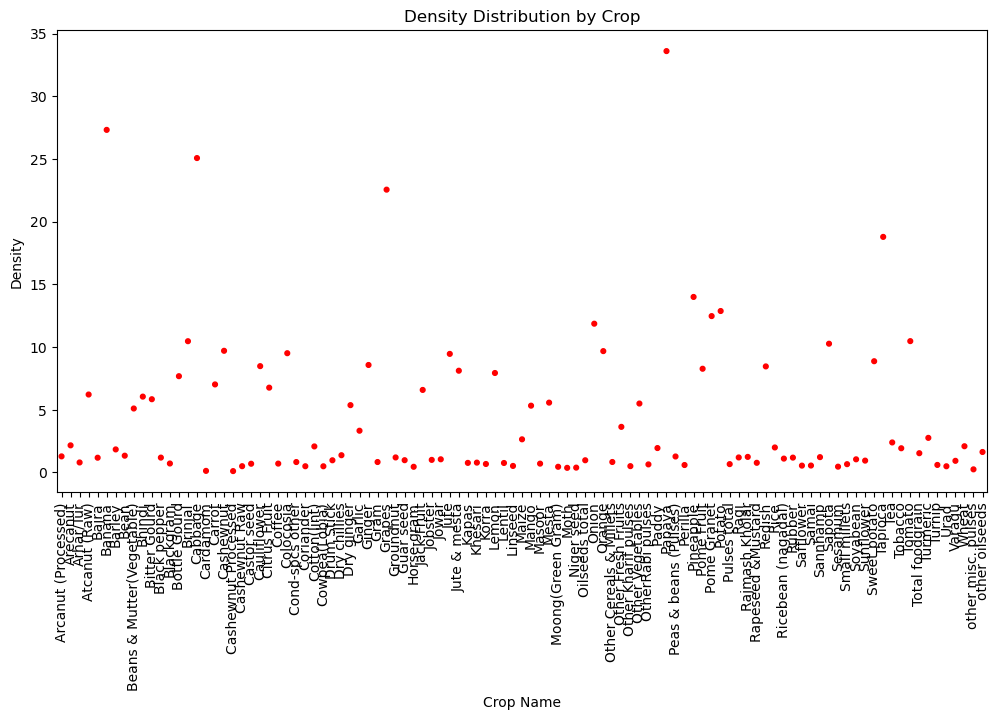

In [61]:
filtered_df2 = df2[(df2['Crop'] != 'Coconut') & (df2['Density'] <= 500)]
filtered_mean_density = mean_density[(mean_density['Crop'] != 'Coconut') & (mean_density['Density'] <= 50)]

plt.figure(figsize=(12, 6))
#sns.boxplot(x='Crop', y='log_density', data=filtered_df2)
sns.pointplot(x='Crop', y='Density', data=filtered_mean_density, color='red', markers='o', scale=0.5, join=False)
plt.title('Density Distribution by Crop')
plt.xlabel('Crop Name')
plt.ylabel('Density')
plt.xticks(rotation=90)
plt.show()

In [62]:
df2[(df2['Crop'] != 'Coconut') & (df2['Density'] > 200)]

,State_Name,Crop,Crop_Year,Season,Production,Area,log_area,log_production,Density,log_density
7612,Maharashtra,Maize,1997,Autumn,19695.0,21.0,3.044522,9.888120,937.857143,6.843598
10788,Punjab,Sugarcane,2011,Whole Year,5653000.0,80.0,4.382027,15.547697,70662.500000,11.165670
11958,Tamil Nadu,Sugarcane,1997,Whole Year,307019000.0,282845.0,12.552654,19.542420,1085.467305,6.989766


Crop affects Crop Density

# State and Crop Density

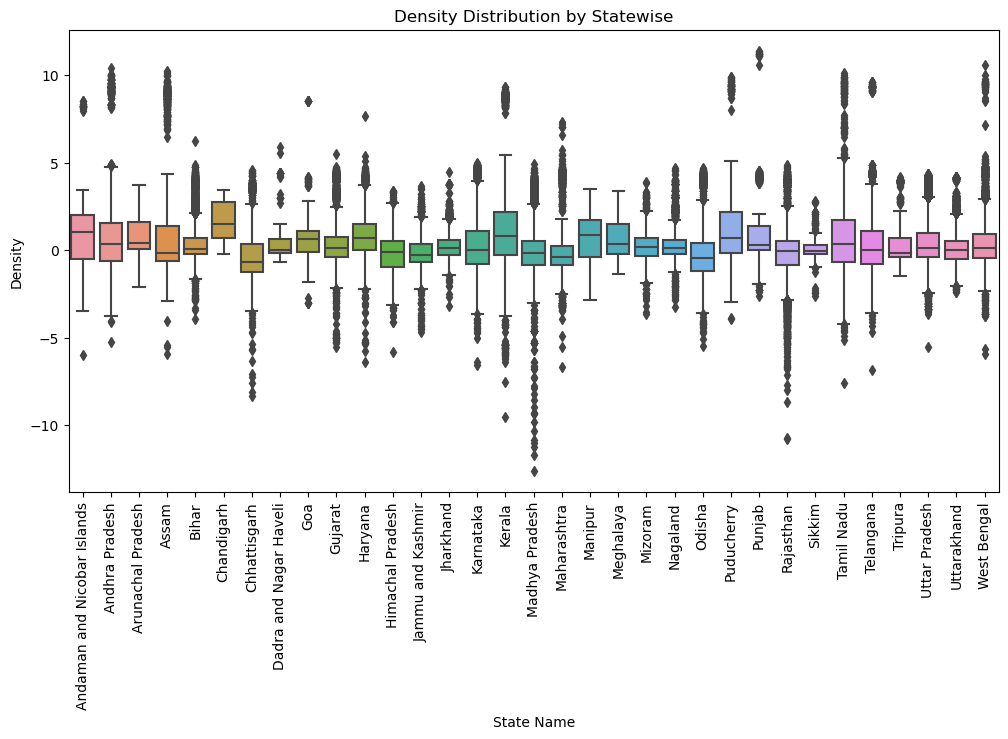

In [63]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='State_Name', y='log_density', data=df1)
plt.title('Density Distribution by Statewise')
plt.xlabel('State Name')
plt.ylabel('Density')
plt.xticks(rotation=90)
plt.show()

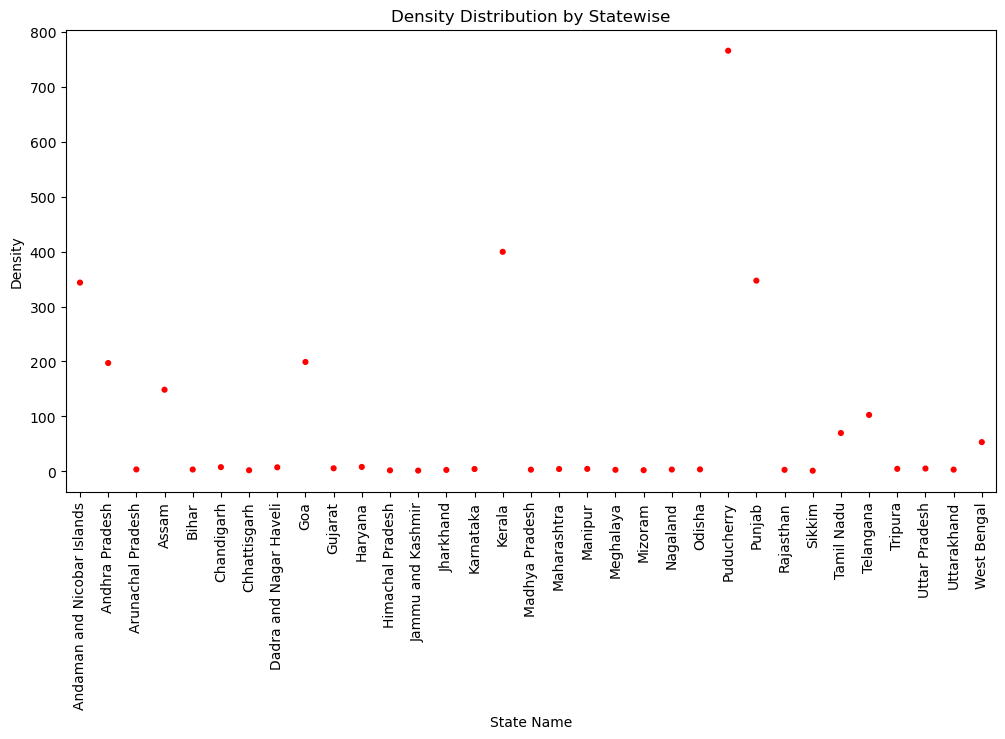

In [64]:
mean_density = df1.groupby('State_Name')['Density'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.pointplot(x='State_Name', y='Density', data=mean_density, color='red', markers='o', scale=0.5, join=False)
plt.title('Density Distribution by Statewise')
plt.xlabel('State Name')
plt.ylabel('Density')
plt.xticks(rotation=90)
plt.show()

Andaman and Nicobar Islands Density normality p-value: 1.3400935472418496e-08
Andhra Pradesh Density normality p-value: 3.544898854780404e-29
Arunachal Pradesh Density normality p-value: 3.463043653922915e-12
Assam Density normality p-value: 1.0190503843549663e-29
Bihar Density normality p-value: 6.958059888392968e-28
Chandigarh Density normality p-value: 2.223104820586741e-05
Chhattisgarh Density normality p-value: 2.3408014791029644e-23
Dadra and Nagar Haveli Density normality p-value: 2.697181383722316e-23
Goa Density normality p-value: 6.011525166549347e-10
Gujarat Density normality p-value: 2.4942746837580743e-21
Haryana Density normality p-value: 1.1651646758537026e-08
Himachal Pradesh Density normality p-value: 6.035275057492129e-11
Jammu and Kashmir Density normality p-value: 2.8840610455382887e-10
Jharkhand Density normality p-value: 1.8168561766174207e-08
Karnataka Density normality p-value: 1.1883805571544226e-12
Kerala Density normality p-value: 3.928454178449023e-19
Madhya

C:\Users\Samuel\anaconda3\lib\site-packages\scipy\integrate\_quadpack_py.py:1151: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


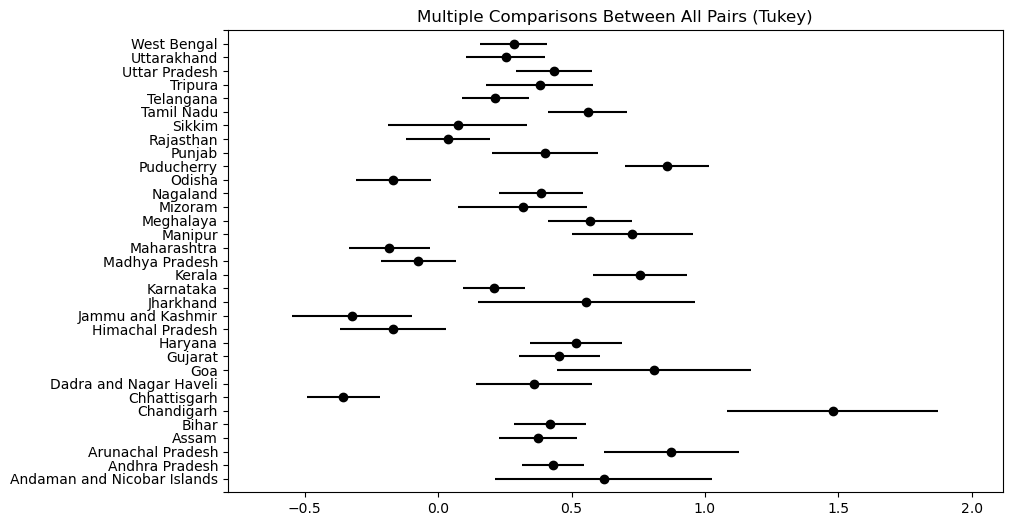

In [65]:
from scipy.stats import shapiro, levene, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd


states = df2['State_Name'].unique()

for state in states:
    stat, p_value = shapiro(df2[df2['State_Name'] == state]['log_density'])
    print(f'{state} Density normality p-value: {p_value}')

    
levene_stat, levene_p_value = levene(*[df2[df2['State_Name'] == state]['log_density'] for state in states])
print(f'\nLevene’s test p-value: {levene_p_value}')


anova_stat, anova_p_value = f_oneway(*[df2[df2['State_Name'] == state]['log_density'] for state in states])
print(f'ANOVA p-value: {anova_p_value}')


if anova_p_value < 0.05:
    tukey = pairwise_tukeyhsd(endog=filtered_df2['log_density'], groups=filtered_df2['State_Name'], alpha=0.05)
    tukey.plot_simultaneous()
    plt.show()
else:
    print("No significant differences found among the states.")

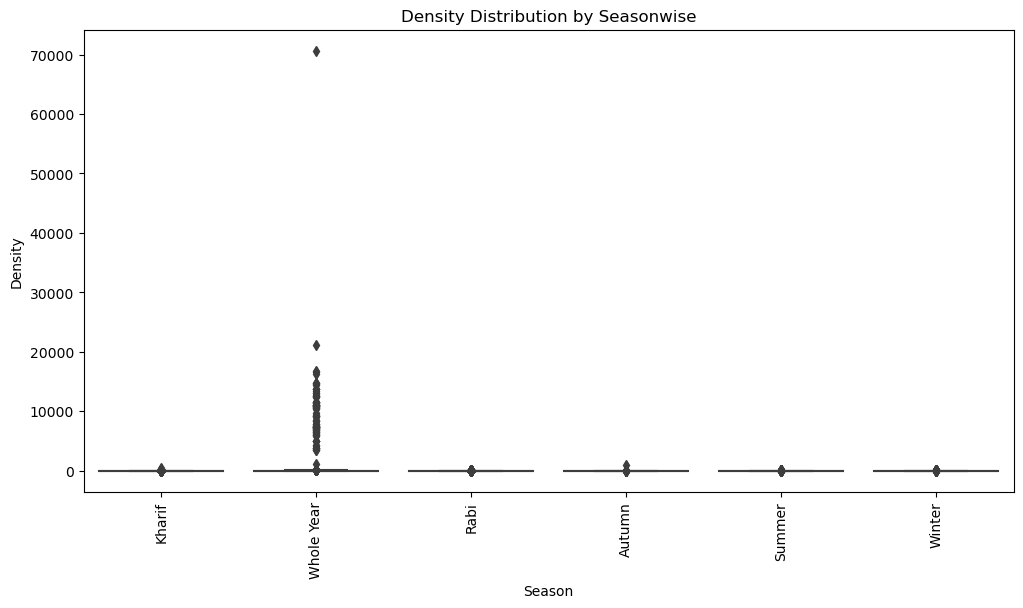

In [66]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Season', y='Density', data=df2)
plt.title('Density Distribution by Seasonwise')
plt.xlabel('Season')
plt.ylabel('Density')
plt.xticks(rotation=90)
plt.show()

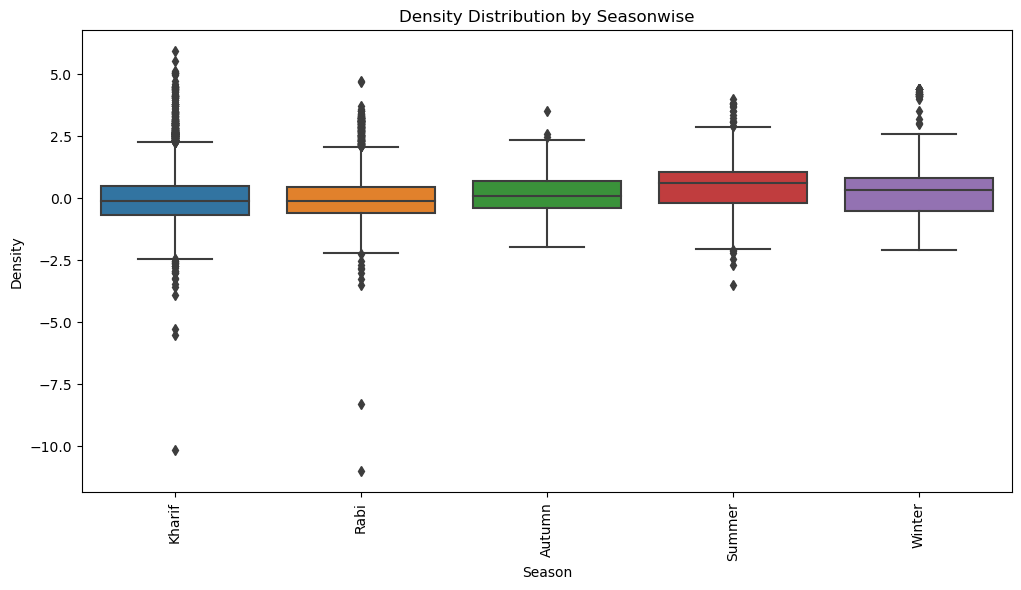

In [67]:
filtered_df2 = df2[(df2['Season'] != 'Whole Year') & (df2['Density'] <= 500)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='Season', y='log_density', data=filtered_df2)
plt.title('Density Distribution by Seasonwise')
plt.xlabel('Season')
plt.ylabel('Density')
plt.xticks(rotation=90)
plt.show()

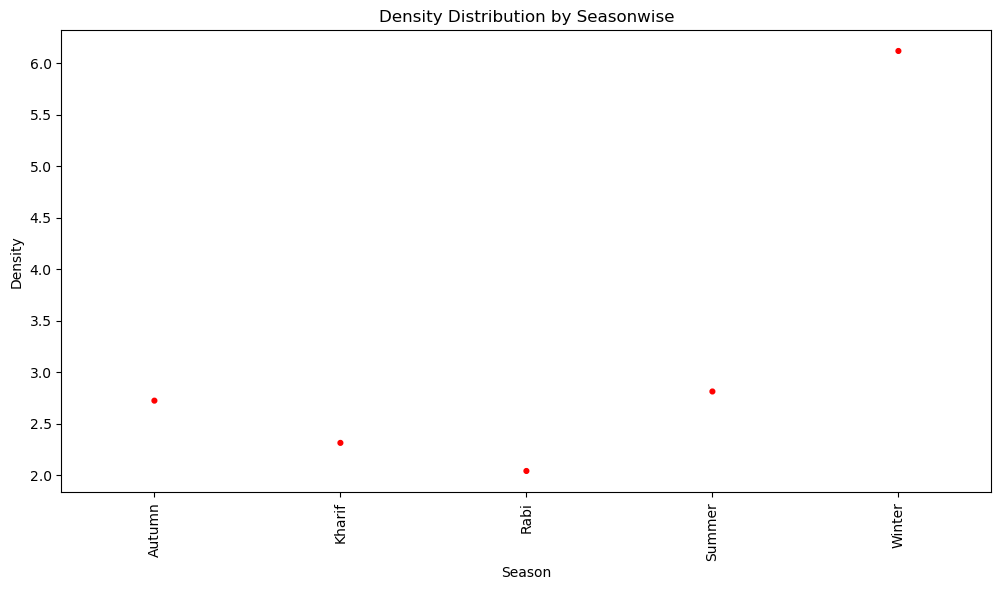

In [68]:
mean_density = df1[df1['Season'] != 'Whole Year'].groupby('Season')['Density'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.pointplot(x='Season', y='Density', data=mean_density, color='red', markers='o', scale=0.5, join=False)
plt.title('Density Distribution by Seasonwise')
plt.xlabel('Season')
plt.ylabel('Density')
plt.xticks(rotation=90)
plt.show()

C:\Users\Samuel\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Kharif Density normality p-value: 4.203895392974451e-45
Rabi Density normality p-value: 9.890378574189202e-40
Autumn Density normality p-value: 1.6495737327204552e-06
Summer Density normality p-value: 1.4194910004372563e-11
Winter Density normality p-value: 2.8867573174278568e-15

Levene’s test p-value: 3.2893988963110665e-19
ANOVA p-value: 7.705474112036246e-42
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
Autumn Kharif  -0.0656 0.8464  -0.241 0.1098  False
Autumn   Rabi  -0.0783 0.7482 -0.2556 0.0989  False
Autumn Summer   0.4194    0.0  0.2194 0.6193   True
Autumn Winter   0.3365 0.0006  0.1062 0.5669   True
Kharif   Rabi  -0.0128 0.9748 -0.0706 0.0451  False
Kharif Summer   0.4849    0.0  0.3758  0.594   True
Kharif Winter   0.4021    0.0  0.2441 0.5601   True
  Rabi Summer   0.4977    0.0  0.3856 0.6098   True
  Rabi Winter   0.4149    0.0  0.2548 0.5749   True
Summer Wint

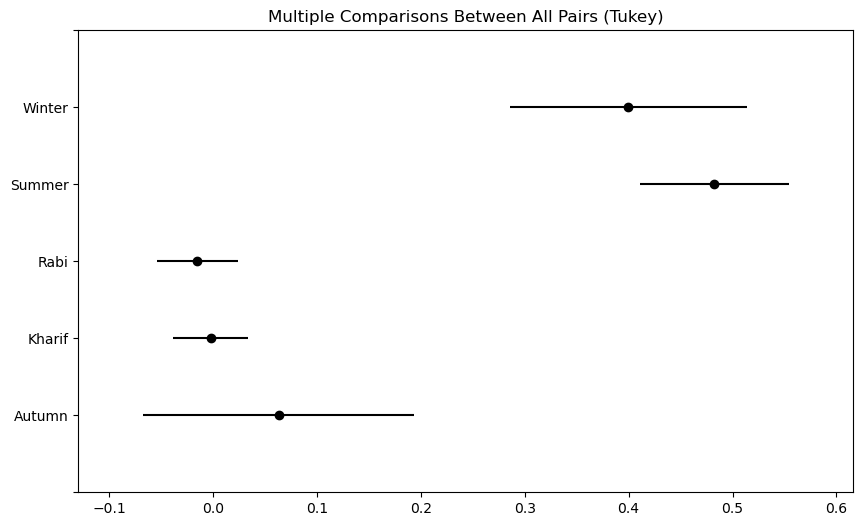

In [69]:
seasons = filtered_df2['Season'].unique()

for season in seasons:
    stat, p_value = shapiro(filtered_df2[filtered_df2['Season'] == season]['log_density'])
    print(f'{season} Density normality p-value: {p_value}')

    
levene_stat, levene_p_value = levene(*[filtered_df2[filtered_df2['Season'] == season]['log_density'] for season in seasons])
print(f'\nLevene’s test p-value: {levene_p_value}')


anova_stat, anova_p_value = f_oneway(*[filtered_df2[filtered_df2['Season'] == season]['log_density'] for season in seasons])
print(f'ANOVA p-value: {anova_p_value}')


if anova_p_value < 0.05:
    tukey = pairwise_tukeyhsd(endog=filtered_df2['log_density'], groups=filtered_df2['Season'], alpha=0.05)
    print(tukey)
    
    tukey.plot_simultaneous()
    plt.show()
else:
    print("No significant differences found among the seasons.")

* Autumn, Kharif, Rabi is a group
* Winter, Summer is group
* Whole Year Crops and Winter Crops tend to have higher crop density

# State vs Season

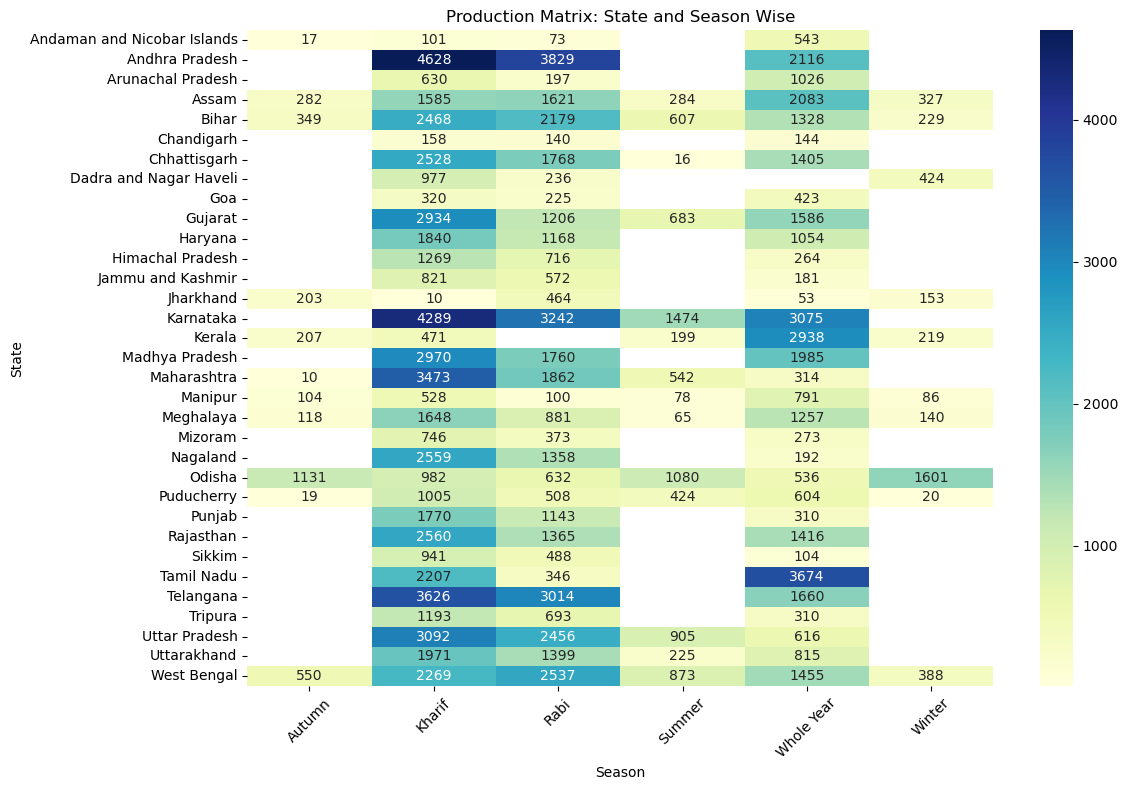

In [70]:
production_state_season = df2.groupby(['State_Name', 'Season'])['log_production'].sum().reset_index()
pivot_production = production_state_season.pivot_table(index='State_Name', columns='Season', values='log_production', aggfunc='sum')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_production, cmap='YlGnBu', annot=True, fmt='.0f', cbar=True)
plt.title('Production Matrix: State and Season Wise')
plt.xlabel('Season')
plt.ylabel('State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

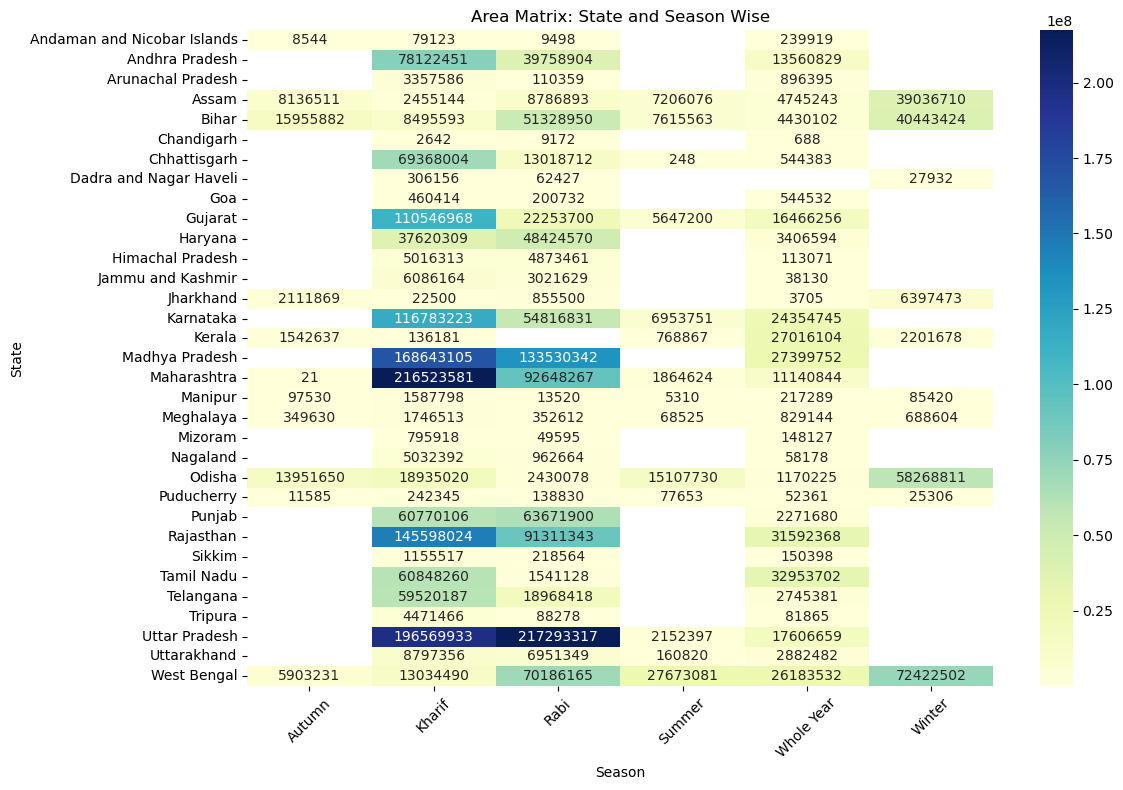

In [71]:
area_state_season = df1.groupby(['State_Name', 'Season'])['Area'].sum().reset_index()
pivot_area = area_state_season.pivot_table(index='State_Name', columns='Season', values='Area', aggfunc='sum')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_area, cmap='YlGnBu', annot=True, fmt='.0f', cbar=True)
plt.title('Area Matrix: State and Season Wise')
plt.xlabel('Season')
plt.ylabel('State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

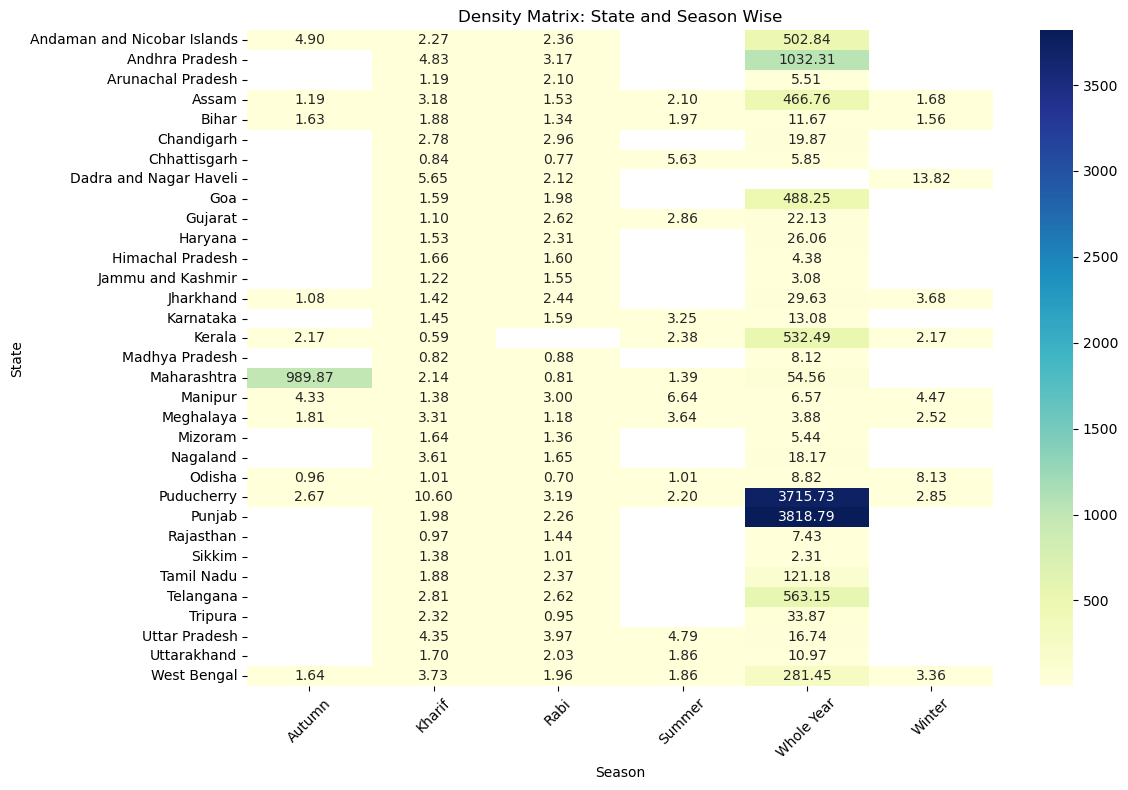

In [72]:
density_state_season = df1.groupby(['State_Name', 'Season'])['Density'].mean().reset_index()
pivot_density = density_state_season.pivot_table(index='State_Name', columns='Season', values='Density', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_density, cmap='YlGnBu', annot=True, fmt='.2f', cbar=True)
plt.title('Density Matrix: State and Season Wise')
plt.xlabel('Season')
plt.ylabel('State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

India has two major agricultural seasons, namely Kharif and Rabi